# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

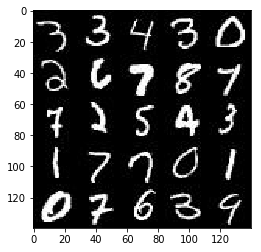

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

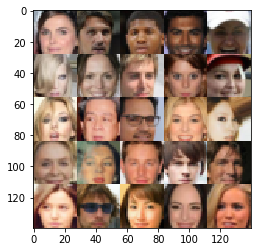

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='inputs_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='inputs_z')
    learning_rate = tf.placeholder(tf.float32, name = 'learning_rate')

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False, n_units=128, alpha=0.1):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 32x32x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        relu1 = tf.maximum(alpha * x1, x1)
        # 16x16x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 8x8x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
         # 4x4x256
            
        relu3 = tf.nn.dropout(relu3, keep_prob=0.8)    

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True, n_units=128, alpha=0.1):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """    
    
    with tf.variable_scope('generator', reuse=not is_train):
               # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 14x14x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 28x28x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 3, strides=1, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        # 28x28xoutput_dim now
        
        out = tf.tanh(logits)
        
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim, smooth=0.1):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)  * (1 - smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
       # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate_scalar, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate_scalar: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    
    show_every = 100
    print_every=5
    n_images=25
    samples, losses = [], []
    steps = 0
    
    inputs_real, inputs_z, learning_rate = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(inputs_real, inputs_z, data_shape[3])
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                batch_images *= 2.0

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={inputs_real: batch_images, inputs_z: batch_z, learning_rate: learning_rate_scalar})
                _ = sess.run(g_train_opt, feed_dict={inputs_z: batch_z, inputs_real: batch_images, learning_rate: learning_rate_scalar})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({inputs_z: batch_z, inputs_real: batch_images})
                    train_loss_g = g_loss.eval({inputs_z: batch_z})

                    print("Step {}/{} Epoch {}/{}...".format(steps, batch_size*epoch_count, epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, n_images, inputs_z, data_shape[3], data_image_mode)
                
    return losses, samples

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Step 5/64 Epoch 1/2... Discriminator Loss: 0.8793... Generator Loss: 1.0287
Step 10/64 Epoch 1/2... Discriminator Loss: 1.1238... Generator Loss: 0.9448
Step 15/64 Epoch 1/2... Discriminator Loss: 0.5232... Generator Loss: 2.0496
Step 20/64 Epoch 1/2... Discriminator Loss: 2.0855... Generator Loss: 0.3717
Step 25/64 Epoch 1/2... Discriminator Loss: 0.3956... Generator Loss: 3.7120
Step 30/64 Epoch 1/2... Discriminator Loss: 0.3702... Generator Loss: 4.1916
Step 35/64 Epoch 1/2... Discriminator Loss: 0.4027... Generator Loss: 3.4078
Step 40/64 Epoch 1/2... Discriminator Loss: 0.3930... Generator Loss: 3.0579
Step 45/64 Epoch 1/2... Discriminator Loss: 1.5443... Generator Loss: 3.5912
Step 50/64 Epoch 1/2... Discriminator Loss: 3.0981... Generator Loss: 0.1091
Step 55/64 Epoch 1/2... Discriminator Loss: 1.0965... Generator Loss: 2.7762
Step 60/64 Epoch 1/2... Discriminator Loss: 1.0285... Generator Loss: 1.3587
Step 65/64 Epoch 1/2... Discriminator Loss: 1.1234... Generator Loss: 0.8492


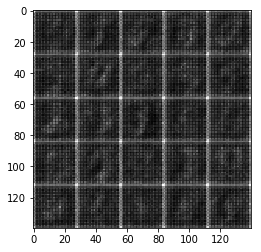

Step 105/64 Epoch 1/2... Discriminator Loss: 1.7443... Generator Loss: 0.3961
Step 110/64 Epoch 1/2... Discriminator Loss: 1.2400... Generator Loss: 1.1781
Step 115/64 Epoch 1/2... Discriminator Loss: 1.4189... Generator Loss: 0.4708
Step 120/64 Epoch 1/2... Discriminator Loss: 1.3186... Generator Loss: 1.0331
Step 125/64 Epoch 1/2... Discriminator Loss: 1.8420... Generator Loss: 0.3450
Step 130/64 Epoch 1/2... Discriminator Loss: 1.3600... Generator Loss: 0.6282
Step 135/64 Epoch 1/2... Discriminator Loss: 1.7125... Generator Loss: 0.3841
Step 140/64 Epoch 1/2... Discriminator Loss: 1.6409... Generator Loss: 1.5601
Step 145/64 Epoch 1/2... Discriminator Loss: 1.5107... Generator Loss: 0.4745
Step 150/64 Epoch 1/2... Discriminator Loss: 1.5565... Generator Loss: 0.9424
Step 155/64 Epoch 1/2... Discriminator Loss: 1.4184... Generator Loss: 0.6204
Step 160/64 Epoch 1/2... Discriminator Loss: 1.4852... Generator Loss: 0.4895
Step 165/64 Epoch 1/2... Discriminator Loss: 1.2170... Generator

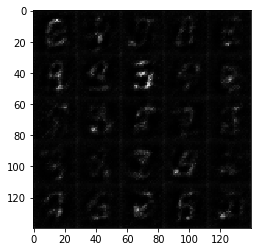

Step 205/64 Epoch 1/2... Discriminator Loss: 1.2517... Generator Loss: 1.7255
Step 210/64 Epoch 1/2... Discriminator Loss: 1.4559... Generator Loss: 0.6279
Step 215/64 Epoch 1/2... Discriminator Loss: 1.2726... Generator Loss: 0.7146
Step 220/64 Epoch 1/2... Discriminator Loss: 1.4203... Generator Loss: 0.4348
Step 225/64 Epoch 1/2... Discriminator Loss: 1.2405... Generator Loss: 1.5437
Step 230/64 Epoch 1/2... Discriminator Loss: 1.6326... Generator Loss: 0.4486
Step 235/64 Epoch 1/2... Discriminator Loss: 1.2888... Generator Loss: 1.4671
Step 240/64 Epoch 1/2... Discriminator Loss: 1.2557... Generator Loss: 0.7371
Step 245/64 Epoch 1/2... Discriminator Loss: 1.2186... Generator Loss: 0.8031
Step 250/64 Epoch 1/2... Discriminator Loss: 1.4722... Generator Loss: 0.5228
Step 255/64 Epoch 1/2... Discriminator Loss: 1.2235... Generator Loss: 1.5255
Step 260/64 Epoch 1/2... Discriminator Loss: 1.1967... Generator Loss: 0.7869
Step 265/64 Epoch 1/2... Discriminator Loss: 1.1347... Generator

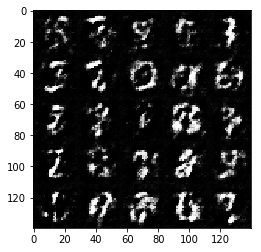

Step 305/64 Epoch 1/2... Discriminator Loss: 1.1379... Generator Loss: 0.6809
Step 310/64 Epoch 1/2... Discriminator Loss: 1.4205... Generator Loss: 1.6501
Step 315/64 Epoch 1/2... Discriminator Loss: 1.3864... Generator Loss: 0.5036
Step 320/64 Epoch 1/2... Discriminator Loss: 1.1500... Generator Loss: 0.7810
Step 325/64 Epoch 1/2... Discriminator Loss: 1.4752... Generator Loss: 0.4589
Step 330/64 Epoch 1/2... Discriminator Loss: 1.0072... Generator Loss: 1.0315
Step 335/64 Epoch 1/2... Discriminator Loss: 1.3040... Generator Loss: 0.5964
Step 340/64 Epoch 1/2... Discriminator Loss: 1.1061... Generator Loss: 1.6187
Step 345/64 Epoch 1/2... Discriminator Loss: 1.5083... Generator Loss: 0.4920
Step 350/64 Epoch 1/2... Discriminator Loss: 1.1768... Generator Loss: 0.8856
Step 355/64 Epoch 1/2... Discriminator Loss: 1.4508... Generator Loss: 0.4840
Step 360/64 Epoch 1/2... Discriminator Loss: 1.2265... Generator Loss: 1.3446
Step 365/64 Epoch 1/2... Discriminator Loss: 1.1965... Generator

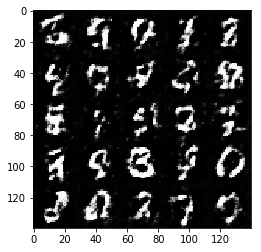

Step 405/64 Epoch 1/2... Discriminator Loss: 0.9360... Generator Loss: 1.7299
Step 410/64 Epoch 1/2... Discriminator Loss: 1.1997... Generator Loss: 0.7970
Step 415/64 Epoch 1/2... Discriminator Loss: 1.0181... Generator Loss: 0.8220
Step 420/64 Epoch 1/2... Discriminator Loss: 0.9252... Generator Loss: 1.4309
Step 425/64 Epoch 1/2... Discriminator Loss: 0.9928... Generator Loss: 1.2196
Step 430/64 Epoch 1/2... Discriminator Loss: 1.0128... Generator Loss: 0.9903
Step 435/64 Epoch 1/2... Discriminator Loss: 1.6115... Generator Loss: 0.4321
Step 440/64 Epoch 1/2... Discriminator Loss: 0.9171... Generator Loss: 1.9239
Step 445/64 Epoch 1/2... Discriminator Loss: 1.6409... Generator Loss: 0.3840
Step 450/64 Epoch 1/2... Discriminator Loss: 1.1407... Generator Loss: 0.7595
Step 455/64 Epoch 1/2... Discriminator Loss: 0.9984... Generator Loss: 1.2045
Step 460/64 Epoch 1/2... Discriminator Loss: 1.2766... Generator Loss: 0.6475
Step 465/64 Epoch 1/2... Discriminator Loss: 1.0432... Generator

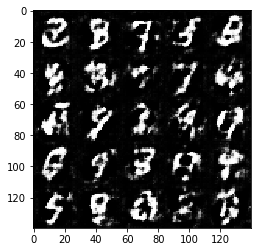

Step 505/64 Epoch 1/2... Discriminator Loss: 1.0812... Generator Loss: 0.8339
Step 510/64 Epoch 1/2... Discriminator Loss: 1.2948... Generator Loss: 0.6626
Step 515/64 Epoch 1/2... Discriminator Loss: 0.9075... Generator Loss: 1.6719
Step 520/64 Epoch 1/2... Discriminator Loss: 0.9447... Generator Loss: 1.3472
Step 525/64 Epoch 1/2... Discriminator Loss: 1.1863... Generator Loss: 0.6578
Step 530/64 Epoch 1/2... Discriminator Loss: 0.9475... Generator Loss: 1.3732
Step 535/64 Epoch 1/2... Discriminator Loss: 1.3604... Generator Loss: 0.5542
Step 540/64 Epoch 1/2... Discriminator Loss: 1.7441... Generator Loss: 0.3613
Step 545/64 Epoch 1/2... Discriminator Loss: 1.0954... Generator Loss: 0.9209
Step 550/64 Epoch 1/2... Discriminator Loss: 1.2674... Generator Loss: 0.6493
Step 555/64 Epoch 1/2... Discriminator Loss: 0.9982... Generator Loss: 1.2344
Step 560/64 Epoch 1/2... Discriminator Loss: 1.1042... Generator Loss: 0.8333
Step 565/64 Epoch 1/2... Discriminator Loss: 1.2916... Generator

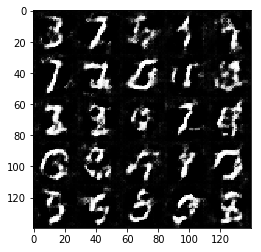

Step 605/64 Epoch 1/2... Discriminator Loss: 1.2140... Generator Loss: 0.6971
Step 610/64 Epoch 1/2... Discriminator Loss: 0.9426... Generator Loss: 1.1304
Step 615/64 Epoch 1/2... Discriminator Loss: 0.9363... Generator Loss: 2.0882
Step 620/64 Epoch 1/2... Discriminator Loss: 1.3915... Generator Loss: 0.6333
Step 625/64 Epoch 1/2... Discriminator Loss: 1.1535... Generator Loss: 1.7346
Step 630/64 Epoch 1/2... Discriminator Loss: 1.0125... Generator Loss: 1.0170
Step 635/64 Epoch 1/2... Discriminator Loss: 2.0437... Generator Loss: 0.2666
Step 640/64 Epoch 1/2... Discriminator Loss: 1.1884... Generator Loss: 1.1043
Step 645/64 Epoch 1/2... Discriminator Loss: 1.6099... Generator Loss: 0.4431
Step 650/64 Epoch 1/2... Discriminator Loss: 1.1854... Generator Loss: 1.6569
Step 655/64 Epoch 1/2... Discriminator Loss: 1.1748... Generator Loss: 0.8416
Step 660/64 Epoch 1/2... Discriminator Loss: 1.2481... Generator Loss: 1.9887
Step 665/64 Epoch 1/2... Discriminator Loss: 1.0766... Generator

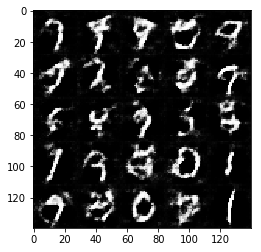

Step 705/64 Epoch 1/2... Discriminator Loss: 1.3280... Generator Loss: 1.6009
Step 710/64 Epoch 1/2... Discriminator Loss: 1.2091... Generator Loss: 1.1162
Step 715/64 Epoch 1/2... Discriminator Loss: 1.4181... Generator Loss: 0.5472
Step 720/64 Epoch 1/2... Discriminator Loss: 1.5440... Generator Loss: 0.4589
Step 725/64 Epoch 1/2... Discriminator Loss: 1.0703... Generator Loss: 1.1656
Step 730/64 Epoch 1/2... Discriminator Loss: 1.1619... Generator Loss: 1.4277
Step 735/64 Epoch 1/2... Discriminator Loss: 1.1621... Generator Loss: 0.8208
Step 740/64 Epoch 1/2... Discriminator Loss: 1.1039... Generator Loss: 1.2466
Step 745/64 Epoch 1/2... Discriminator Loss: 1.5074... Generator Loss: 0.5218
Step 750/64 Epoch 1/2... Discriminator Loss: 1.1319... Generator Loss: 1.2207
Step 755/64 Epoch 1/2... Discriminator Loss: 1.4696... Generator Loss: 0.4940
Step 760/64 Epoch 1/2... Discriminator Loss: 1.3772... Generator Loss: 1.7139
Step 765/64 Epoch 1/2... Discriminator Loss: 1.3492... Generator

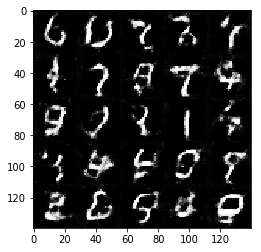

Step 805/64 Epoch 1/2... Discriminator Loss: 1.4889... Generator Loss: 0.4508
Step 810/64 Epoch 1/2... Discriminator Loss: 1.3267... Generator Loss: 0.7234
Step 815/64 Epoch 1/2... Discriminator Loss: 1.0672... Generator Loss: 1.0824
Step 820/64 Epoch 1/2... Discriminator Loss: 1.1192... Generator Loss: 1.7321
Step 825/64 Epoch 1/2... Discriminator Loss: 1.2576... Generator Loss: 1.2173
Step 830/64 Epoch 1/2... Discriminator Loss: 1.2285... Generator Loss: 0.7141
Step 835/64 Epoch 1/2... Discriminator Loss: 1.1986... Generator Loss: 0.6764
Step 840/64 Epoch 1/2... Discriminator Loss: 1.0589... Generator Loss: 1.5237
Step 845/64 Epoch 1/2... Discriminator Loss: 1.7439... Generator Loss: 0.3126
Step 850/64 Epoch 1/2... Discriminator Loss: 1.1215... Generator Loss: 1.0394
Step 855/64 Epoch 1/2... Discriminator Loss: 1.0548... Generator Loss: 0.8717
Step 860/64 Epoch 1/2... Discriminator Loss: 1.4272... Generator Loss: 0.5228
Step 865/64 Epoch 1/2... Discriminator Loss: 1.1059... Generator

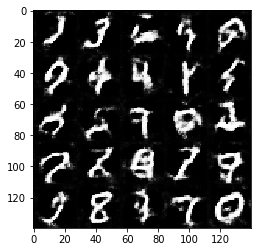

Step 905/64 Epoch 1/2... Discriminator Loss: 1.0659... Generator Loss: 1.2291
Step 910/64 Epoch 1/2... Discriminator Loss: 1.5820... Generator Loss: 0.4849
Step 915/64 Epoch 1/2... Discriminator Loss: 1.2234... Generator Loss: 1.2296
Step 920/64 Epoch 1/2... Discriminator Loss: 1.3177... Generator Loss: 0.6531
Step 925/64 Epoch 1/2... Discriminator Loss: 1.1089... Generator Loss: 1.0191
Step 930/64 Epoch 1/2... Discriminator Loss: 1.7661... Generator Loss: 0.3760
Step 935/64 Epoch 1/2... Discriminator Loss: 1.3432... Generator Loss: 0.5800
Step 940/64 Epoch 1/2... Discriminator Loss: 1.1204... Generator Loss: 1.2636
Step 945/64 Epoch 1/2... Discriminator Loss: 1.2320... Generator Loss: 0.7354
Step 950/64 Epoch 1/2... Discriminator Loss: 1.0793... Generator Loss: 1.0090
Step 955/64 Epoch 1/2... Discriminator Loss: 1.2024... Generator Loss: 0.7562
Step 960/64 Epoch 1/2... Discriminator Loss: 1.1682... Generator Loss: 1.1788
Step 965/64 Epoch 1/2... Discriminator Loss: 1.5502... Generator

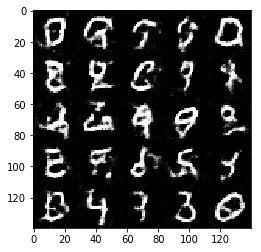

Step 1005/64 Epoch 1/2... Discriminator Loss: 1.3090... Generator Loss: 0.5296
Step 1010/64 Epoch 1/2... Discriminator Loss: 1.0916... Generator Loss: 1.2541
Step 1015/64 Epoch 1/2... Discriminator Loss: 1.0582... Generator Loss: 1.1174
Step 1020/64 Epoch 1/2... Discriminator Loss: 1.5631... Generator Loss: 0.5304
Step 1025/64 Epoch 1/2... Discriminator Loss: 1.2386... Generator Loss: 1.3979
Step 1030/64 Epoch 1/2... Discriminator Loss: 1.3311... Generator Loss: 0.6183
Step 1035/64 Epoch 1/2... Discriminator Loss: 1.1159... Generator Loss: 1.2236
Step 1040/64 Epoch 1/2... Discriminator Loss: 1.4223... Generator Loss: 0.5620
Step 1045/64 Epoch 1/2... Discriminator Loss: 1.3300... Generator Loss: 0.6307
Step 1050/64 Epoch 1/2... Discriminator Loss: 1.2335... Generator Loss: 0.7415
Step 1055/64 Epoch 1/2... Discriminator Loss: 1.1736... Generator Loss: 0.7124
Step 1060/64 Epoch 1/2... Discriminator Loss: 1.2895... Generator Loss: 2.0679
Step 1065/64 Epoch 1/2... Discriminator Loss: 1.4505

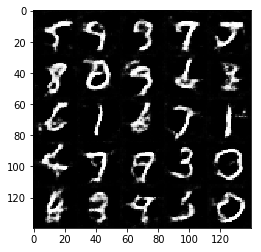

Step 1105/64 Epoch 1/2... Discriminator Loss: 1.3377... Generator Loss: 0.6860
Step 1110/64 Epoch 1/2... Discriminator Loss: 1.2740... Generator Loss: 0.5368
Step 1115/64 Epoch 1/2... Discriminator Loss: 1.6770... Generator Loss: 0.3983
Step 1120/64 Epoch 1/2... Discriminator Loss: 1.2036... Generator Loss: 1.3002
Step 1125/64 Epoch 1/2... Discriminator Loss: 1.0795... Generator Loss: 1.2587
Step 1130/64 Epoch 1/2... Discriminator Loss: 1.3953... Generator Loss: 0.5987
Step 1135/64 Epoch 1/2... Discriminator Loss: 1.0533... Generator Loss: 1.1909
Step 1140/64 Epoch 1/2... Discriminator Loss: 1.1444... Generator Loss: 0.7254
Step 1145/64 Epoch 1/2... Discriminator Loss: 1.1278... Generator Loss: 0.9212
Step 1150/64 Epoch 1/2... Discriminator Loss: 1.1125... Generator Loss: 0.8971
Step 1155/64 Epoch 1/2... Discriminator Loss: 1.0353... Generator Loss: 1.1462
Step 1160/64 Epoch 1/2... Discriminator Loss: 1.5254... Generator Loss: 0.5106
Step 1165/64 Epoch 1/2... Discriminator Loss: 1.2397

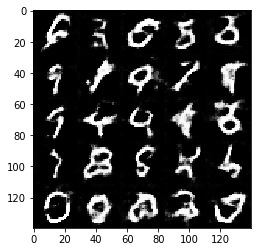

Step 1205/64 Epoch 1/2... Discriminator Loss: 1.0525... Generator Loss: 1.1200
Step 1210/64 Epoch 1/2... Discriminator Loss: 1.1445... Generator Loss: 1.1319
Step 1215/64 Epoch 1/2... Discriminator Loss: 1.5487... Generator Loss: 0.4952
Step 1220/64 Epoch 1/2... Discriminator Loss: 1.3262... Generator Loss: 1.2900
Step 1225/64 Epoch 1/2... Discriminator Loss: 1.4032... Generator Loss: 0.6611
Step 1230/64 Epoch 1/2... Discriminator Loss: 1.0549... Generator Loss: 0.9275
Step 1235/64 Epoch 1/2... Discriminator Loss: 1.0824... Generator Loss: 0.9222
Step 1240/64 Epoch 1/2... Discriminator Loss: 1.0614... Generator Loss: 1.1241
Step 1245/64 Epoch 1/2... Discriminator Loss: 0.9814... Generator Loss: 0.9032
Step 1250/64 Epoch 1/2... Discriminator Loss: 1.3317... Generator Loss: 0.5939
Step 1255/64 Epoch 1/2... Discriminator Loss: 1.0237... Generator Loss: 1.2239
Step 1260/64 Epoch 1/2... Discriminator Loss: 1.4135... Generator Loss: 0.5655
Step 1265/64 Epoch 1/2... Discriminator Loss: 1.1672

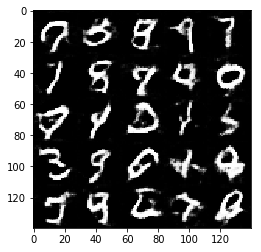

Step 1305/64 Epoch 1/2... Discriminator Loss: 1.0753... Generator Loss: 1.0030
Step 1310/64 Epoch 1/2... Discriminator Loss: 1.2383... Generator Loss: 0.7859
Step 1315/64 Epoch 1/2... Discriminator Loss: 1.5148... Generator Loss: 0.4315
Step 1320/64 Epoch 1/2... Discriminator Loss: 1.0829... Generator Loss: 0.9105
Step 1325/64 Epoch 1/2... Discriminator Loss: 1.1029... Generator Loss: 0.8588
Step 1330/64 Epoch 1/2... Discriminator Loss: 1.6293... Generator Loss: 0.4291
Step 1335/64 Epoch 1/2... Discriminator Loss: 1.0226... Generator Loss: 1.5745
Step 1340/64 Epoch 1/2... Discriminator Loss: 1.4338... Generator Loss: 0.6076
Step 1345/64 Epoch 1/2... Discriminator Loss: 1.1693... Generator Loss: 1.3888
Step 1350/64 Epoch 1/2... Discriminator Loss: 1.3836... Generator Loss: 0.4755
Step 1355/64 Epoch 1/2... Discriminator Loss: 1.2219... Generator Loss: 0.7932
Step 1360/64 Epoch 1/2... Discriminator Loss: 1.0399... Generator Loss: 1.1329
Step 1365/64 Epoch 1/2... Discriminator Loss: 1.1901

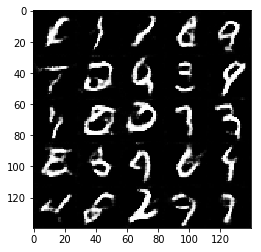

Step 1405/64 Epoch 1/2... Discriminator Loss: 1.4097... Generator Loss: 0.6524
Step 1410/64 Epoch 1/2... Discriminator Loss: 1.0808... Generator Loss: 1.0557
Step 1415/64 Epoch 1/2... Discriminator Loss: 1.1457... Generator Loss: 0.7699
Step 1420/64 Epoch 1/2... Discriminator Loss: 1.1254... Generator Loss: 0.9047
Step 1425/64 Epoch 1/2... Discriminator Loss: 1.2677... Generator Loss: 0.7604
Step 1430/64 Epoch 1/2... Discriminator Loss: 1.1850... Generator Loss: 0.6809
Step 1435/64 Epoch 1/2... Discriminator Loss: 1.1293... Generator Loss: 0.7323
Step 1440/64 Epoch 1/2... Discriminator Loss: 1.5323... Generator Loss: 0.4872
Step 1445/64 Epoch 1/2... Discriminator Loss: 1.2812... Generator Loss: 0.6130
Step 1450/64 Epoch 1/2... Discriminator Loss: 1.5060... Generator Loss: 0.4602
Step 1455/64 Epoch 1/2... Discriminator Loss: 1.2754... Generator Loss: 1.8398
Step 1460/64 Epoch 1/2... Discriminator Loss: 0.9718... Generator Loss: 1.1402
Step 1465/64 Epoch 1/2... Discriminator Loss: 1.1117

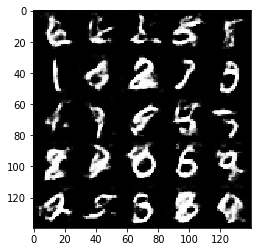

Step 1505/64 Epoch 1/2... Discriminator Loss: 1.4967... Generator Loss: 0.3502
Step 1510/64 Epoch 1/2... Discriminator Loss: 1.0969... Generator Loss: 1.0101
Step 1515/64 Epoch 1/2... Discriminator Loss: 1.2555... Generator Loss: 0.8230
Step 1520/64 Epoch 1/2... Discriminator Loss: 1.5985... Generator Loss: 0.4135
Step 1525/64 Epoch 1/2... Discriminator Loss: 1.1140... Generator Loss: 1.0472
Step 1530/64 Epoch 1/2... Discriminator Loss: 1.6259... Generator Loss: 0.4606
Step 1535/64 Epoch 1/2... Discriminator Loss: 0.9549... Generator Loss: 1.1248
Step 1540/64 Epoch 1/2... Discriminator Loss: 1.0547... Generator Loss: 0.9002
Step 1545/64 Epoch 1/2... Discriminator Loss: 1.1280... Generator Loss: 1.0123
Step 1550/64 Epoch 1/2... Discriminator Loss: 1.2846... Generator Loss: 1.5117
Step 1555/64 Epoch 1/2... Discriminator Loss: 1.0590... Generator Loss: 0.8510
Step 1560/64 Epoch 1/2... Discriminator Loss: 1.0449... Generator Loss: 0.7772
Step 1565/64 Epoch 1/2... Discriminator Loss: 1.1311

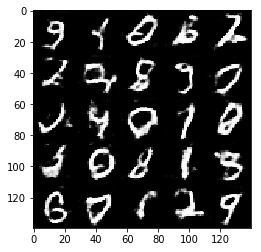

Step 1605/64 Epoch 1/2... Discriminator Loss: 1.4788... Generator Loss: 0.4949
Step 1610/64 Epoch 1/2... Discriminator Loss: 1.1665... Generator Loss: 1.4030
Step 1615/64 Epoch 1/2... Discriminator Loss: 1.0561... Generator Loss: 1.0287
Step 1620/64 Epoch 1/2... Discriminator Loss: 1.1701... Generator Loss: 0.6688
Step 1625/64 Epoch 1/2... Discriminator Loss: 1.1733... Generator Loss: 1.1755
Step 1630/64 Epoch 1/2... Discriminator Loss: 1.1888... Generator Loss: 0.8768
Step 1635/64 Epoch 1/2... Discriminator Loss: 1.1142... Generator Loss: 1.0188
Step 1640/64 Epoch 1/2... Discriminator Loss: 1.3533... Generator Loss: 0.6445
Step 1645/64 Epoch 1/2... Discriminator Loss: 1.0856... Generator Loss: 1.8959
Step 1650/64 Epoch 1/2... Discriminator Loss: 1.1965... Generator Loss: 0.9155
Step 1655/64 Epoch 1/2... Discriminator Loss: 1.1362... Generator Loss: 0.9024
Step 1660/64 Epoch 1/2... Discriminator Loss: 1.2021... Generator Loss: 0.7642
Step 1665/64 Epoch 1/2... Discriminator Loss: 1.2824

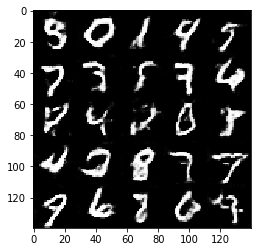

Step 1705/64 Epoch 1/2... Discriminator Loss: 1.1544... Generator Loss: 1.7056
Step 1710/64 Epoch 1/2... Discriminator Loss: 1.3045... Generator Loss: 0.6203
Step 1715/64 Epoch 1/2... Discriminator Loss: 1.0645... Generator Loss: 1.1217
Step 1720/64 Epoch 1/2... Discriminator Loss: 1.6310... Generator Loss: 0.4775
Step 1725/64 Epoch 1/2... Discriminator Loss: 1.0078... Generator Loss: 1.2446
Step 1730/64 Epoch 1/2... Discriminator Loss: 1.2536... Generator Loss: 0.6831
Step 1735/64 Epoch 1/2... Discriminator Loss: 1.4717... Generator Loss: 0.6538
Step 1740/64 Epoch 1/2... Discriminator Loss: 1.3864... Generator Loss: 0.6521
Step 1745/64 Epoch 1/2... Discriminator Loss: 1.7867... Generator Loss: 0.3438
Step 1750/64 Epoch 1/2... Discriminator Loss: 1.1975... Generator Loss: 1.6904
Step 1755/64 Epoch 1/2... Discriminator Loss: 1.2171... Generator Loss: 0.7818
Step 1760/64 Epoch 1/2... Discriminator Loss: 1.0578... Generator Loss: 1.3312
Step 1765/64 Epoch 1/2... Discriminator Loss: 1.2999

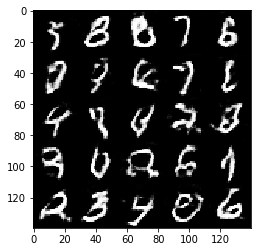

Step 1805/64 Epoch 1/2... Discriminator Loss: 1.5838... Generator Loss: 0.4999
Step 1810/64 Epoch 1/2... Discriminator Loss: 1.1093... Generator Loss: 1.3023
Step 1815/64 Epoch 1/2... Discriminator Loss: 1.0267... Generator Loss: 0.8943
Step 1820/64 Epoch 1/2... Discriminator Loss: 1.5760... Generator Loss: 0.5664
Step 1825/64 Epoch 1/2... Discriminator Loss: 1.0214... Generator Loss: 0.9378
Step 1830/64 Epoch 1/2... Discriminator Loss: 1.5713... Generator Loss: 0.4000
Step 1835/64 Epoch 1/2... Discriminator Loss: 1.0429... Generator Loss: 0.7696
Step 1840/64 Epoch 1/2... Discriminator Loss: 1.3624... Generator Loss: 0.5796
Step 1845/64 Epoch 1/2... Discriminator Loss: 1.1019... Generator Loss: 0.9994
Step 1850/64 Epoch 1/2... Discriminator Loss: 1.2391... Generator Loss: 0.7353
Step 1855/64 Epoch 1/2... Discriminator Loss: 1.0129... Generator Loss: 1.4893
Step 1860/64 Epoch 1/2... Discriminator Loss: 1.5228... Generator Loss: 0.4823
Step 1865/64 Epoch 1/2... Discriminator Loss: 1.3601

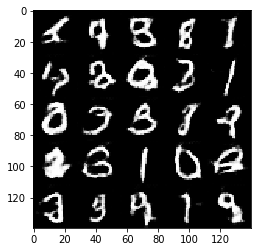

Step 1905/64 Epoch 2/2... Discriminator Loss: 0.9661... Generator Loss: 1.0619
Step 1910/64 Epoch 2/2... Discriminator Loss: 1.2778... Generator Loss: 0.7130
Step 1915/64 Epoch 2/2... Discriminator Loss: 1.0832... Generator Loss: 1.3916
Step 1920/64 Epoch 2/2... Discriminator Loss: 1.0463... Generator Loss: 0.8870
Step 1925/64 Epoch 2/2... Discriminator Loss: 1.4336... Generator Loss: 0.4710
Step 1930/64 Epoch 2/2... Discriminator Loss: 1.0568... Generator Loss: 1.1294
Step 1935/64 Epoch 2/2... Discriminator Loss: 1.3788... Generator Loss: 0.6715
Step 1940/64 Epoch 2/2... Discriminator Loss: 1.0317... Generator Loss: 1.5672
Step 1945/64 Epoch 2/2... Discriminator Loss: 1.1193... Generator Loss: 0.8281
Step 1950/64 Epoch 2/2... Discriminator Loss: 0.9994... Generator Loss: 0.9654
Step 1955/64 Epoch 2/2... Discriminator Loss: 1.0285... Generator Loss: 0.9668
Step 1960/64 Epoch 2/2... Discriminator Loss: 1.0513... Generator Loss: 0.8095
Step 1965/64 Epoch 2/2... Discriminator Loss: 1.1363

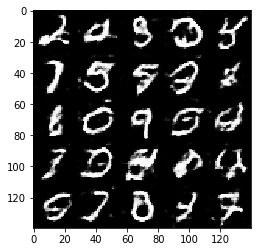

Step 2005/64 Epoch 2/2... Discriminator Loss: 1.3493... Generator Loss: 0.6435
Step 2010/64 Epoch 2/2... Discriminator Loss: 0.9223... Generator Loss: 1.1819
Step 2015/64 Epoch 2/2... Discriminator Loss: 1.0871... Generator Loss: 1.0413
Step 2020/64 Epoch 2/2... Discriminator Loss: 0.9496... Generator Loss: 1.0971
Step 2025/64 Epoch 2/2... Discriminator Loss: 1.1430... Generator Loss: 0.8338
Step 2030/64 Epoch 2/2... Discriminator Loss: 1.1612... Generator Loss: 0.8573
Step 2035/64 Epoch 2/2... Discriminator Loss: 1.5531... Generator Loss: 0.4798
Step 2040/64 Epoch 2/2... Discriminator Loss: 1.1994... Generator Loss: 0.7702
Step 2045/64 Epoch 2/2... Discriminator Loss: 1.2675... Generator Loss: 0.7717
Step 2050/64 Epoch 2/2... Discriminator Loss: 1.2268... Generator Loss: 1.0210
Step 2055/64 Epoch 2/2... Discriminator Loss: 1.1419... Generator Loss: 0.7605
Step 2060/64 Epoch 2/2... Discriminator Loss: 1.3824... Generator Loss: 0.4738
Step 2065/64 Epoch 2/2... Discriminator Loss: 1.1505

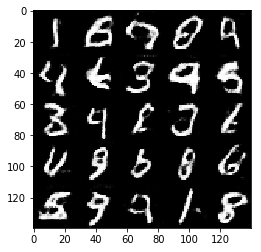

Step 2105/64 Epoch 2/2... Discriminator Loss: 1.4332... Generator Loss: 0.5202
Step 2110/64 Epoch 2/2... Discriminator Loss: 1.0455... Generator Loss: 1.3907
Step 2115/64 Epoch 2/2... Discriminator Loss: 1.1243... Generator Loss: 0.8851
Step 2120/64 Epoch 2/2... Discriminator Loss: 1.4170... Generator Loss: 0.5610
Step 2125/64 Epoch 2/2... Discriminator Loss: 1.1107... Generator Loss: 0.8512
Step 2130/64 Epoch 2/2... Discriminator Loss: 1.0340... Generator Loss: 1.6257
Step 2135/64 Epoch 2/2... Discriminator Loss: 1.2056... Generator Loss: 0.7797
Step 2140/64 Epoch 2/2... Discriminator Loss: 1.3857... Generator Loss: 0.4927
Step 2145/64 Epoch 2/2... Discriminator Loss: 1.2851... Generator Loss: 0.8366
Step 2150/64 Epoch 2/2... Discriminator Loss: 1.0679... Generator Loss: 0.9238
Step 2155/64 Epoch 2/2... Discriminator Loss: 0.9590... Generator Loss: 0.9885
Step 2160/64 Epoch 2/2... Discriminator Loss: 1.2179... Generator Loss: 1.2220
Step 2165/64 Epoch 2/2... Discriminator Loss: 1.5864

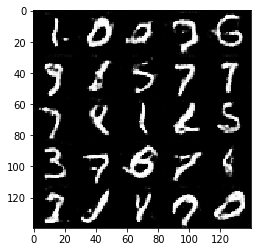

Step 2205/64 Epoch 2/2... Discriminator Loss: 1.2478... Generator Loss: 0.6579
Step 2210/64 Epoch 2/2... Discriminator Loss: 1.1536... Generator Loss: 1.5977
Step 2215/64 Epoch 2/2... Discriminator Loss: 1.3873... Generator Loss: 0.6024
Step 2220/64 Epoch 2/2... Discriminator Loss: 1.3753... Generator Loss: 0.6303
Step 2225/64 Epoch 2/2... Discriminator Loss: 1.0252... Generator Loss: 0.8995
Step 2230/64 Epoch 2/2... Discriminator Loss: 1.1151... Generator Loss: 1.1135
Step 2235/64 Epoch 2/2... Discriminator Loss: 1.6243... Generator Loss: 0.4612
Step 2240/64 Epoch 2/2... Discriminator Loss: 0.9859... Generator Loss: 1.2070
Step 2245/64 Epoch 2/2... Discriminator Loss: 1.3842... Generator Loss: 1.5022
Step 2250/64 Epoch 2/2... Discriminator Loss: 1.0119... Generator Loss: 1.1563
Step 2255/64 Epoch 2/2... Discriminator Loss: 1.2980... Generator Loss: 0.6587
Step 2260/64 Epoch 2/2... Discriminator Loss: 0.9676... Generator Loss: 1.4946
Step 2265/64 Epoch 2/2... Discriminator Loss: 1.2101

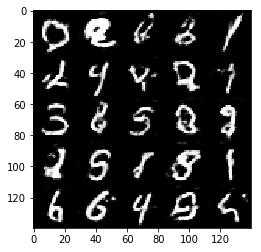

Step 2305/64 Epoch 2/2... Discriminator Loss: 1.9539... Generator Loss: 2.6432
Step 2310/64 Epoch 2/2... Discriminator Loss: 1.7640... Generator Loss: 0.3434
Step 2315/64 Epoch 2/2... Discriminator Loss: 1.2118... Generator Loss: 0.8007
Step 2320/64 Epoch 2/2... Discriminator Loss: 1.2531... Generator Loss: 0.6821
Step 2325/64 Epoch 2/2... Discriminator Loss: 1.1006... Generator Loss: 0.7813
Step 2330/64 Epoch 2/2... Discriminator Loss: 1.2598... Generator Loss: 0.7733
Step 2335/64 Epoch 2/2... Discriminator Loss: 1.1228... Generator Loss: 1.4565
Step 2340/64 Epoch 2/2... Discriminator Loss: 1.1287... Generator Loss: 0.9711
Step 2345/64 Epoch 2/2... Discriminator Loss: 1.3894... Generator Loss: 0.6499
Step 2350/64 Epoch 2/2... Discriminator Loss: 1.0338... Generator Loss: 0.7685
Step 2355/64 Epoch 2/2... Discriminator Loss: 1.0395... Generator Loss: 0.8144
Step 2360/64 Epoch 2/2... Discriminator Loss: 1.0627... Generator Loss: 0.8747
Step 2365/64 Epoch 2/2... Discriminator Loss: 1.0475

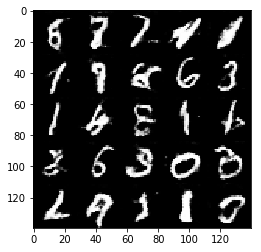

Step 2405/64 Epoch 2/2... Discriminator Loss: 1.5199... Generator Loss: 0.4743
Step 2410/64 Epoch 2/2... Discriminator Loss: 1.1942... Generator Loss: 0.7558
Step 2415/64 Epoch 2/2... Discriminator Loss: 1.4762... Generator Loss: 0.5367
Step 2420/64 Epoch 2/2... Discriminator Loss: 1.3969... Generator Loss: 0.4563
Step 2425/64 Epoch 2/2... Discriminator Loss: 1.2214... Generator Loss: 0.6928
Step 2430/64 Epoch 2/2... Discriminator Loss: 0.9756... Generator Loss: 1.2205
Step 2435/64 Epoch 2/2... Discriminator Loss: 1.0382... Generator Loss: 0.9358
Step 2440/64 Epoch 2/2... Discriminator Loss: 0.9978... Generator Loss: 1.0076
Step 2445/64 Epoch 2/2... Discriminator Loss: 1.1866... Generator Loss: 0.6985
Step 2450/64 Epoch 2/2... Discriminator Loss: 1.1932... Generator Loss: 0.7501
Step 2455/64 Epoch 2/2... Discriminator Loss: 1.2378... Generator Loss: 2.0790
Step 2460/64 Epoch 2/2... Discriminator Loss: 1.4936... Generator Loss: 0.5467
Step 2465/64 Epoch 2/2... Discriminator Loss: 1.0217

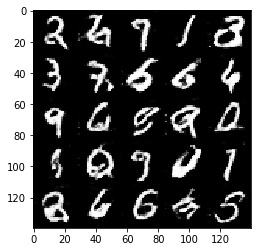

Step 2505/64 Epoch 2/2... Discriminator Loss: 1.1403... Generator Loss: 1.6911
Step 2510/64 Epoch 2/2... Discriminator Loss: 1.3977... Generator Loss: 0.5383
Step 2515/64 Epoch 2/2... Discriminator Loss: 1.2043... Generator Loss: 0.6894
Step 2520/64 Epoch 2/2... Discriminator Loss: 1.1960... Generator Loss: 1.5019
Step 2525/64 Epoch 2/2... Discriminator Loss: 1.1562... Generator Loss: 0.8121
Step 2530/64 Epoch 2/2... Discriminator Loss: 1.1776... Generator Loss: 0.7587
Step 2535/64 Epoch 2/2... Discriminator Loss: 1.2070... Generator Loss: 1.3674
Step 2540/64 Epoch 2/2... Discriminator Loss: 1.1042... Generator Loss: 0.7854
Step 2545/64 Epoch 2/2... Discriminator Loss: 0.9202... Generator Loss: 1.1095
Step 2550/64 Epoch 2/2... Discriminator Loss: 1.1135... Generator Loss: 0.7894
Step 2555/64 Epoch 2/2... Discriminator Loss: 0.8954... Generator Loss: 1.2815
Step 2560/64 Epoch 2/2... Discriminator Loss: 1.1099... Generator Loss: 0.7288
Step 2565/64 Epoch 2/2... Discriminator Loss: 1.2019

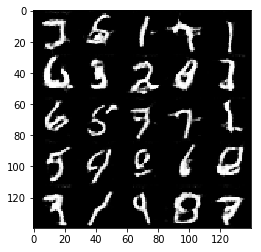

Step 2605/64 Epoch 2/2... Discriminator Loss: 0.9985... Generator Loss: 1.0432
Step 2610/64 Epoch 2/2... Discriminator Loss: 1.1403... Generator Loss: 1.5062
Step 2615/64 Epoch 2/2... Discriminator Loss: 1.0848... Generator Loss: 0.9095
Step 2620/64 Epoch 2/2... Discriminator Loss: 1.3140... Generator Loss: 0.5706
Step 2625/64 Epoch 2/2... Discriminator Loss: 1.4559... Generator Loss: 0.4496
Step 2630/64 Epoch 2/2... Discriminator Loss: 0.8841... Generator Loss: 1.2731
Step 2635/64 Epoch 2/2... Discriminator Loss: 1.3190... Generator Loss: 0.5790
Step 2640/64 Epoch 2/2... Discriminator Loss: 0.9320... Generator Loss: 1.2140
Step 2645/64 Epoch 2/2... Discriminator Loss: 1.0130... Generator Loss: 1.4964
Step 2650/64 Epoch 2/2... Discriminator Loss: 1.0756... Generator Loss: 0.7495
Step 2655/64 Epoch 2/2... Discriminator Loss: 1.4178... Generator Loss: 0.6302
Step 2660/64 Epoch 2/2... Discriminator Loss: 1.2707... Generator Loss: 1.3117
Step 2665/64 Epoch 2/2... Discriminator Loss: 1.1805

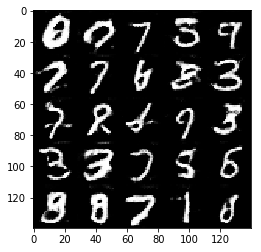

Step 2705/64 Epoch 2/2... Discriminator Loss: 0.8363... Generator Loss: 1.5492
Step 2710/64 Epoch 2/2... Discriminator Loss: 1.0017... Generator Loss: 1.0361
Step 2715/64 Epoch 2/2... Discriminator Loss: 1.1318... Generator Loss: 0.8341
Step 2720/64 Epoch 2/2... Discriminator Loss: 0.9664... Generator Loss: 1.3104
Step 2725/64 Epoch 2/2... Discriminator Loss: 0.9641... Generator Loss: 1.0522
Step 2730/64 Epoch 2/2... Discriminator Loss: 0.8990... Generator Loss: 1.1649
Step 2735/64 Epoch 2/2... Discriminator Loss: 1.1121... Generator Loss: 0.7776
Step 2740/64 Epoch 2/2... Discriminator Loss: 1.2634... Generator Loss: 0.8116
Step 2745/64 Epoch 2/2... Discriminator Loss: 1.6938... Generator Loss: 0.3817
Step 2750/64 Epoch 2/2... Discriminator Loss: 0.9895... Generator Loss: 1.3088
Step 2755/64 Epoch 2/2... Discriminator Loss: 1.2571... Generator Loss: 0.5991
Step 2760/64 Epoch 2/2... Discriminator Loss: 1.5115... Generator Loss: 0.4958
Step 2765/64 Epoch 2/2... Discriminator Loss: 1.2867

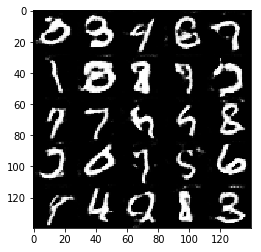

Step 2805/64 Epoch 2/2... Discriminator Loss: 1.3143... Generator Loss: 0.7871
Step 2810/64 Epoch 2/2... Discriminator Loss: 0.9890... Generator Loss: 1.1135
Step 2815/64 Epoch 2/2... Discriminator Loss: 1.0298... Generator Loss: 0.9652
Step 2820/64 Epoch 2/2... Discriminator Loss: 0.8987... Generator Loss: 1.1667
Step 2825/64 Epoch 2/2... Discriminator Loss: 1.1834... Generator Loss: 0.7906
Step 2830/64 Epoch 2/2... Discriminator Loss: 1.4587... Generator Loss: 0.5266
Step 2835/64 Epoch 2/2... Discriminator Loss: 1.1850... Generator Loss: 0.7911
Step 2840/64 Epoch 2/2... Discriminator Loss: 1.2977... Generator Loss: 0.5967
Step 2845/64 Epoch 2/2... Discriminator Loss: 0.9232... Generator Loss: 1.0694
Step 2850/64 Epoch 2/2... Discriminator Loss: 1.0348... Generator Loss: 0.9122
Step 2855/64 Epoch 2/2... Discriminator Loss: 0.9505... Generator Loss: 1.0549
Step 2860/64 Epoch 2/2... Discriminator Loss: 1.0438... Generator Loss: 0.9424
Step 2865/64 Epoch 2/2... Discriminator Loss: 1.2621

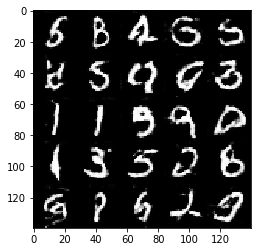

Step 2905/64 Epoch 2/2... Discriminator Loss: 1.0222... Generator Loss: 1.5619
Step 2910/64 Epoch 2/2... Discriminator Loss: 0.9782... Generator Loss: 1.0006
Step 2915/64 Epoch 2/2... Discriminator Loss: 1.4068... Generator Loss: 0.5072
Step 2920/64 Epoch 2/2... Discriminator Loss: 1.4261... Generator Loss: 2.0842
Step 2925/64 Epoch 2/2... Discriminator Loss: 2.1525... Generator Loss: 0.2205
Step 2930/64 Epoch 2/2... Discriminator Loss: 1.0584... Generator Loss: 1.2085
Step 2935/64 Epoch 2/2... Discriminator Loss: 0.8812... Generator Loss: 1.2801
Step 2940/64 Epoch 2/2... Discriminator Loss: 0.9759... Generator Loss: 0.9680
Step 2945/64 Epoch 2/2... Discriminator Loss: 1.0503... Generator Loss: 1.1887
Step 2950/64 Epoch 2/2... Discriminator Loss: 0.9020... Generator Loss: 1.0947
Step 2955/64 Epoch 2/2... Discriminator Loss: 1.5455... Generator Loss: 0.5178
Step 2960/64 Epoch 2/2... Discriminator Loss: 1.3683... Generator Loss: 1.9010
Step 2965/64 Epoch 2/2... Discriminator Loss: 1.1537

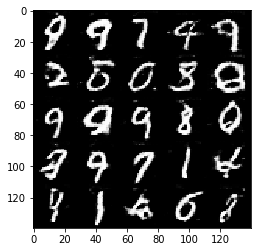

Step 3005/64 Epoch 2/2... Discriminator Loss: 0.7742... Generator Loss: 1.2507
Step 3010/64 Epoch 2/2... Discriminator Loss: 1.2020... Generator Loss: 0.7424
Step 3015/64 Epoch 2/2... Discriminator Loss: 1.0897... Generator Loss: 0.9537
Step 3020/64 Epoch 2/2... Discriminator Loss: 0.8207... Generator Loss: 1.7049
Step 3025/64 Epoch 2/2... Discriminator Loss: 1.0152... Generator Loss: 0.8340
Step 3030/64 Epoch 2/2... Discriminator Loss: 0.8038... Generator Loss: 1.6946
Step 3035/64 Epoch 2/2... Discriminator Loss: 1.2763... Generator Loss: 0.7419
Step 3040/64 Epoch 2/2... Discriminator Loss: 1.4055... Generator Loss: 1.8868
Step 3045/64 Epoch 2/2... Discriminator Loss: 1.2221... Generator Loss: 0.6895
Step 3050/64 Epoch 2/2... Discriminator Loss: 0.9923... Generator Loss: 1.4002
Step 3055/64 Epoch 2/2... Discriminator Loss: 1.0707... Generator Loss: 0.8211
Step 3060/64 Epoch 2/2... Discriminator Loss: 1.1774... Generator Loss: 0.6645
Step 3065/64 Epoch 2/2... Discriminator Loss: 1.1172

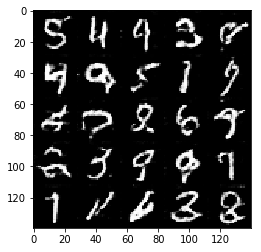

Step 3105/64 Epoch 2/2... Discriminator Loss: 1.0367... Generator Loss: 1.0044
Step 3110/64 Epoch 2/2... Discriminator Loss: 0.8647... Generator Loss: 1.4761
Step 3115/64 Epoch 2/2... Discriminator Loss: 0.9200... Generator Loss: 1.4082
Step 3120/64 Epoch 2/2... Discriminator Loss: 0.9953... Generator Loss: 1.7822
Step 3125/64 Epoch 2/2... Discriminator Loss: 0.9203... Generator Loss: 1.1046
Step 3130/64 Epoch 2/2... Discriminator Loss: 0.9230... Generator Loss: 1.1613
Step 3135/64 Epoch 2/2... Discriminator Loss: 0.9230... Generator Loss: 1.2594
Step 3140/64 Epoch 2/2... Discriminator Loss: 0.8812... Generator Loss: 1.1726
Step 3145/64 Epoch 2/2... Discriminator Loss: 1.2695... Generator Loss: 0.5849
Step 3150/64 Epoch 2/2... Discriminator Loss: 0.9972... Generator Loss: 0.9566
Step 3155/64 Epoch 2/2... Discriminator Loss: 0.7526... Generator Loss: 1.4648
Step 3160/64 Epoch 2/2... Discriminator Loss: 0.8092... Generator Loss: 1.5179
Step 3165/64 Epoch 2/2... Discriminator Loss: 1.0544

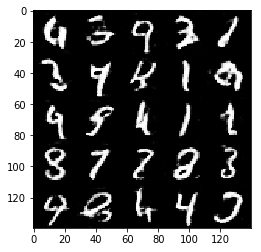

Step 3205/64 Epoch 2/2... Discriminator Loss: 0.9506... Generator Loss: 1.2050
Step 3210/64 Epoch 2/2... Discriminator Loss: 0.9167... Generator Loss: 1.3660
Step 3215/64 Epoch 2/2... Discriminator Loss: 1.2668... Generator Loss: 0.6239
Step 3220/64 Epoch 2/2... Discriminator Loss: 0.8793... Generator Loss: 1.2366
Step 3225/64 Epoch 2/2... Discriminator Loss: 1.0507... Generator Loss: 1.9360
Step 3230/64 Epoch 2/2... Discriminator Loss: 1.0345... Generator Loss: 0.8678
Step 3235/64 Epoch 2/2... Discriminator Loss: 0.7516... Generator Loss: 1.4086
Step 3240/64 Epoch 2/2... Discriminator Loss: 1.0155... Generator Loss: 0.9963
Step 3245/64 Epoch 2/2... Discriminator Loss: 0.8585... Generator Loss: 1.1985
Step 3250/64 Epoch 2/2... Discriminator Loss: 1.1101... Generator Loss: 0.8827
Step 3255/64 Epoch 2/2... Discriminator Loss: 1.9059... Generator Loss: 2.1751
Step 3260/64 Epoch 2/2... Discriminator Loss: 2.6415... Generator Loss: 0.1988
Step 3265/64 Epoch 2/2... Discriminator Loss: 1.3763

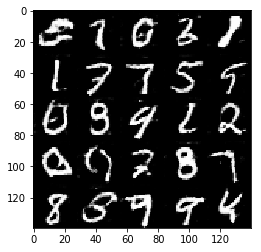

Step 3305/64 Epoch 2/2... Discriminator Loss: 1.2931... Generator Loss: 0.6966
Step 3310/64 Epoch 2/2... Discriminator Loss: 1.0820... Generator Loss: 1.2701
Step 3315/64 Epoch 2/2... Discriminator Loss: 0.9694... Generator Loss: 0.9698
Step 3320/64 Epoch 2/2... Discriminator Loss: 1.2284... Generator Loss: 0.7267
Step 3325/64 Epoch 2/2... Discriminator Loss: 1.0488... Generator Loss: 0.7940
Step 3330/64 Epoch 2/2... Discriminator Loss: 1.0798... Generator Loss: 0.8411
Step 3335/64 Epoch 2/2... Discriminator Loss: 0.8193... Generator Loss: 1.4073
Step 3340/64 Epoch 2/2... Discriminator Loss: 0.9826... Generator Loss: 1.0515
Step 3345/64 Epoch 2/2... Discriminator Loss: 0.8237... Generator Loss: 1.1537
Step 3350/64 Epoch 2/2... Discriminator Loss: 0.9995... Generator Loss: 1.2687
Step 3355/64 Epoch 2/2... Discriminator Loss: 0.6134... Generator Loss: 1.9949
Step 3360/64 Epoch 2/2... Discriminator Loss: 0.9661... Generator Loss: 1.8149
Step 3365/64 Epoch 2/2... Discriminator Loss: 1.4036

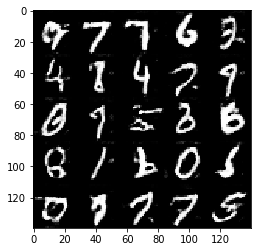

Step 3405/64 Epoch 2/2... Discriminator Loss: 1.2127... Generator Loss: 0.9395
Step 3410/64 Epoch 2/2... Discriminator Loss: 1.0400... Generator Loss: 2.4289
Step 3415/64 Epoch 2/2... Discriminator Loss: 1.7165... Generator Loss: 0.3826
Step 3420/64 Epoch 2/2... Discriminator Loss: 1.0587... Generator Loss: 0.9298
Step 3425/64 Epoch 2/2... Discriminator Loss: 1.1783... Generator Loss: 0.9023
Step 3430/64 Epoch 2/2... Discriminator Loss: 1.0263... Generator Loss: 2.0778
Step 3435/64 Epoch 2/2... Discriminator Loss: 1.5871... Generator Loss: 0.4266
Step 3440/64 Epoch 2/2... Discriminator Loss: 0.8907... Generator Loss: 1.3877
Step 3445/64 Epoch 2/2... Discriminator Loss: 1.0796... Generator Loss: 1.0056
Step 3450/64 Epoch 2/2... Discriminator Loss: 1.0814... Generator Loss: 0.9071
Step 3455/64 Epoch 2/2... Discriminator Loss: 0.9366... Generator Loss: 1.0322
Step 3460/64 Epoch 2/2... Discriminator Loss: 0.9698... Generator Loss: 0.9673
Step 3465/64 Epoch 2/2... Discriminator Loss: 1.0299

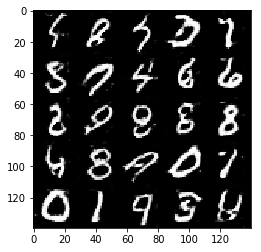

Step 3505/64 Epoch 2/2... Discriminator Loss: 0.8688... Generator Loss: 1.5551
Step 3510/64 Epoch 2/2... Discriminator Loss: 1.0979... Generator Loss: 1.1007
Step 3515/64 Epoch 2/2... Discriminator Loss: 0.8689... Generator Loss: 1.2283
Step 3520/64 Epoch 2/2... Discriminator Loss: 1.0296... Generator Loss: 1.7299
Step 3525/64 Epoch 2/2... Discriminator Loss: 0.9845... Generator Loss: 1.0727
Step 3530/64 Epoch 2/2... Discriminator Loss: 0.9091... Generator Loss: 1.0443
Step 3535/64 Epoch 2/2... Discriminator Loss: 0.9083... Generator Loss: 1.4093
Step 3540/64 Epoch 2/2... Discriminator Loss: 0.8879... Generator Loss: 1.2964
Step 3545/64 Epoch 2/2... Discriminator Loss: 0.9286... Generator Loss: 1.4015
Step 3550/64 Epoch 2/2... Discriminator Loss: 1.1063... Generator Loss: 0.8427
Step 3555/64 Epoch 2/2... Discriminator Loss: 1.0000... Generator Loss: 1.1851
Step 3560/64 Epoch 2/2... Discriminator Loss: 1.0978... Generator Loss: 1.0066
Step 3565/64 Epoch 2/2... Discriminator Loss: 0.9053

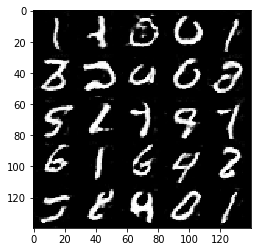

Step 3605/64 Epoch 2/2... Discriminator Loss: 1.5284... Generator Loss: 0.4539
Step 3610/64 Epoch 2/2... Discriminator Loss: 1.2433... Generator Loss: 1.5963
Step 3615/64 Epoch 2/2... Discriminator Loss: 1.2782... Generator Loss: 0.6490
Step 3620/64 Epoch 2/2... Discriminator Loss: 1.1580... Generator Loss: 0.7437
Step 3625/64 Epoch 2/2... Discriminator Loss: 1.2476... Generator Loss: 0.6628
Step 3630/64 Epoch 2/2... Discriminator Loss: 1.5150... Generator Loss: 0.5485
Step 3635/64 Epoch 2/2... Discriminator Loss: 0.7332... Generator Loss: 2.1627
Step 3640/64 Epoch 2/2... Discriminator Loss: 1.6489... Generator Loss: 0.4240
Step 3645/64 Epoch 2/2... Discriminator Loss: 1.2225... Generator Loss: 0.8030
Step 3650/64 Epoch 2/2... Discriminator Loss: 1.0987... Generator Loss: 2.1458
Step 3655/64 Epoch 2/2... Discriminator Loss: 1.5599... Generator Loss: 0.6245
Step 3660/64 Epoch 2/2... Discriminator Loss: 1.1033... Generator Loss: 0.8738
Step 3665/64 Epoch 2/2... Discriminator Loss: 0.9540

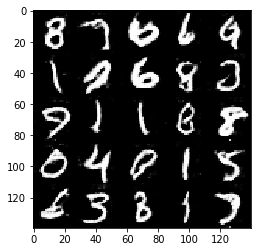

Step 3705/64 Epoch 2/2... Discriminator Loss: 1.2643... Generator Loss: 0.6456
Step 3710/64 Epoch 2/2... Discriminator Loss: 0.8076... Generator Loss: 1.7542
Step 3715/64 Epoch 2/2... Discriminator Loss: 0.9755... Generator Loss: 0.9913
Step 3720/64 Epoch 2/2... Discriminator Loss: 1.3919... Generator Loss: 1.8508
Step 3725/64 Epoch 2/2... Discriminator Loss: 1.1351... Generator Loss: 0.9142
Step 3730/64 Epoch 2/2... Discriminator Loss: 0.7900... Generator Loss: 1.5845
Step 3735/64 Epoch 2/2... Discriminator Loss: 0.9796... Generator Loss: 1.3308
Step 3740/64 Epoch 2/2... Discriminator Loss: 1.1493... Generator Loss: 0.8245
Step 3745/64 Epoch 2/2... Discriminator Loss: 0.9307... Generator Loss: 1.0518
Step 3750/64 Epoch 2/2... Discriminator Loss: 0.9671... Generator Loss: 1.4445


In [12]:
batch_size = 32
z_dim = 100
learning_rate_scalar = 0.0001
beta1 = 0.1


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate_scalar, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Step 5/32 Epoch 1/1... Discriminator Loss: 3.4148... Generator Loss: 0.0778
Step 10/32 Epoch 1/1... Discriminator Loss: 3.4638... Generator Loss: 0.0724
Step 15/32 Epoch 1/1... Discriminator Loss: 2.4507... Generator Loss: 0.2216
Step 20/32 Epoch 1/1... Discriminator Loss: 1.8974... Generator Loss: 0.4263
Step 25/32 Epoch 1/1... Discriminator Loss: 0.9658... Generator Loss: 1.2527
Step 30/32 Epoch 1/1... Discriminator Loss: 0.7339... Generator Loss: 1.5861
Step 35/32 Epoch 1/1... Discriminator Loss: 0.8422... Generator Loss: 1.2955
Step 40/32 Epoch 1/1... Discriminator Loss: 1.1525... Generator Loss: 0.7726
Step 45/32 Epoch 1/1... Discriminator Loss: 1.1401... Generator Loss: 5.0152
Step 50/32 Epoch 1/1... Discriminator Loss: 0.8285... Generator Loss: 1.1764
Step 55/32 Epoch 1/1... Discriminator Loss: 0.7860... Generator Loss: 3.0916
Step 60/32 Epoch 1/1... Discriminator Loss: 1.7473... Generator Loss: 0.4007
Step 65/32 Epoch 1/1... Discriminator Loss: 0.6582... Generator Loss: 2.4542


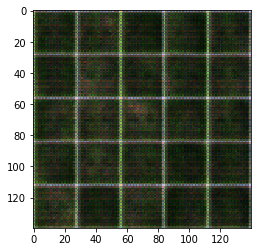

Step 105/32 Epoch 1/1... Discriminator Loss: 0.5683... Generator Loss: 2.1804
Step 110/32 Epoch 1/1... Discriminator Loss: 1.3993... Generator Loss: 4.7550
Step 115/32 Epoch 1/1... Discriminator Loss: 1.6823... Generator Loss: 0.3347
Step 120/32 Epoch 1/1... Discriminator Loss: 0.8437... Generator Loss: 2.6463
Step 125/32 Epoch 1/1... Discriminator Loss: 0.7257... Generator Loss: 1.6916
Step 130/32 Epoch 1/1... Discriminator Loss: 0.6301... Generator Loss: 1.8290
Step 135/32 Epoch 1/1... Discriminator Loss: 2.7563... Generator Loss: 0.1434
Step 140/32 Epoch 1/1... Discriminator Loss: 0.5389... Generator Loss: 2.5378
Step 145/32 Epoch 1/1... Discriminator Loss: 1.5477... Generator Loss: 0.4149
Step 150/32 Epoch 1/1... Discriminator Loss: 1.0387... Generator Loss: 1.0146
Step 155/32 Epoch 1/1... Discriminator Loss: 1.4860... Generator Loss: 0.5747
Step 160/32 Epoch 1/1... Discriminator Loss: 0.8452... Generator Loss: 2.9588
Step 165/32 Epoch 1/1... Discriminator Loss: 0.7138... Generator

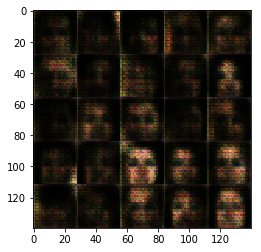

Step 205/32 Epoch 1/1... Discriminator Loss: 1.1921... Generator Loss: 0.6600
Step 210/32 Epoch 1/1... Discriminator Loss: 1.0690... Generator Loss: 4.1474
Step 215/32 Epoch 1/1... Discriminator Loss: 2.0699... Generator Loss: 0.2144
Step 220/32 Epoch 1/1... Discriminator Loss: 1.1375... Generator Loss: 3.6818
Step 225/32 Epoch 1/1... Discriminator Loss: 1.9435... Generator Loss: 0.3404
Step 230/32 Epoch 1/1... Discriminator Loss: 0.7354... Generator Loss: 1.3296
Step 235/32 Epoch 1/1... Discriminator Loss: 0.6742... Generator Loss: 1.5007
Step 240/32 Epoch 1/1... Discriminator Loss: 1.3399... Generator Loss: 0.6003
Step 245/32 Epoch 1/1... Discriminator Loss: 0.8133... Generator Loss: 3.7794
Step 250/32 Epoch 1/1... Discriminator Loss: 0.6418... Generator Loss: 2.5171
Step 255/32 Epoch 1/1... Discriminator Loss: 1.4520... Generator Loss: 0.5363
Step 260/32 Epoch 1/1... Discriminator Loss: 0.5381... Generator Loss: 2.9058
Step 265/32 Epoch 1/1... Discriminator Loss: 1.2954... Generator

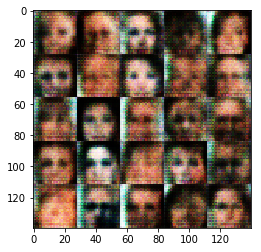

Step 305/32 Epoch 1/1... Discriminator Loss: 0.8989... Generator Loss: 3.5413
Step 310/32 Epoch 1/1... Discriminator Loss: 0.8131... Generator Loss: 1.2522
Step 315/32 Epoch 1/1... Discriminator Loss: 0.5094... Generator Loss: 3.2567
Step 320/32 Epoch 1/1... Discriminator Loss: 0.8924... Generator Loss: 1.0196
Step 325/32 Epoch 1/1... Discriminator Loss: 0.5802... Generator Loss: 2.2674
Step 330/32 Epoch 1/1... Discriminator Loss: 0.8878... Generator Loss: 1.1738
Step 335/32 Epoch 1/1... Discriminator Loss: 0.6095... Generator Loss: 2.9908
Step 340/32 Epoch 1/1... Discriminator Loss: 1.1686... Generator Loss: 0.6399
Step 345/32 Epoch 1/1... Discriminator Loss: 0.5308... Generator Loss: 2.9279
Step 350/32 Epoch 1/1... Discriminator Loss: 0.8710... Generator Loss: 1.1300
Step 355/32 Epoch 1/1... Discriminator Loss: 0.5750... Generator Loss: 1.7593
Step 360/32 Epoch 1/1... Discriminator Loss: 0.5657... Generator Loss: 2.8555
Step 365/32 Epoch 1/1... Discriminator Loss: 1.2673... Generator

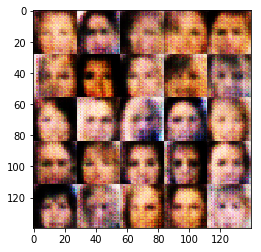

Step 405/32 Epoch 1/1... Discriminator Loss: 1.0477... Generator Loss: 0.8817
Step 410/32 Epoch 1/1... Discriminator Loss: 0.5231... Generator Loss: 2.1330
Step 415/32 Epoch 1/1... Discriminator Loss: 1.2350... Generator Loss: 0.6920
Step 420/32 Epoch 1/1... Discriminator Loss: 0.4748... Generator Loss: 2.7980
Step 425/32 Epoch 1/1... Discriminator Loss: 1.9233... Generator Loss: 0.3036
Step 430/32 Epoch 1/1... Discriminator Loss: 0.9552... Generator Loss: 3.0534
Step 435/32 Epoch 1/1... Discriminator Loss: 1.2290... Generator Loss: 0.6283
Step 440/32 Epoch 1/1... Discriminator Loss: 0.5858... Generator Loss: 2.5808
Step 445/32 Epoch 1/1... Discriminator Loss: 0.8982... Generator Loss: 1.1472
Step 450/32 Epoch 1/1... Discriminator Loss: 0.8049... Generator Loss: 4.1533
Step 455/32 Epoch 1/1... Discriminator Loss: 0.8309... Generator Loss: 1.3000
Step 460/32 Epoch 1/1... Discriminator Loss: 1.6203... Generator Loss: 3.4364
Step 465/32 Epoch 1/1... Discriminator Loss: 0.4756... Generator

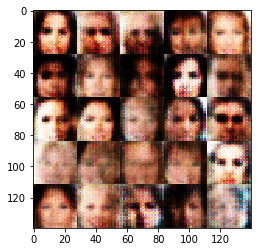

Step 505/32 Epoch 1/1... Discriminator Loss: 0.5997... Generator Loss: 5.5524
Step 510/32 Epoch 1/1... Discriminator Loss: 1.6099... Generator Loss: 0.3833
Step 515/32 Epoch 1/1... Discriminator Loss: 1.0247... Generator Loss: 0.9666
Step 520/32 Epoch 1/1... Discriminator Loss: 0.5306... Generator Loss: 5.9649
Step 525/32 Epoch 1/1... Discriminator Loss: 1.3306... Generator Loss: 0.6224
Step 530/32 Epoch 1/1... Discriminator Loss: 0.7912... Generator Loss: 3.6752
Step 535/32 Epoch 1/1... Discriminator Loss: 0.6990... Generator Loss: 2.0722
Step 540/32 Epoch 1/1... Discriminator Loss: 0.6602... Generator Loss: 2.1333
Step 545/32 Epoch 1/1... Discriminator Loss: 0.7358... Generator Loss: 2.2881
Step 550/32 Epoch 1/1... Discriminator Loss: 0.9479... Generator Loss: 0.9680
Step 555/32 Epoch 1/1... Discriminator Loss: 0.8524... Generator Loss: 2.1221
Step 560/32 Epoch 1/1... Discriminator Loss: 1.7093... Generator Loss: 0.4241
Step 565/32 Epoch 1/1... Discriminator Loss: 1.2952... Generator

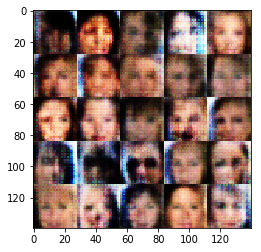

Step 605/32 Epoch 1/1... Discriminator Loss: 1.2580... Generator Loss: 0.7787
Step 610/32 Epoch 1/1... Discriminator Loss: 0.8111... Generator Loss: 3.5178
Step 615/32 Epoch 1/1... Discriminator Loss: 1.3562... Generator Loss: 0.6457
Step 620/32 Epoch 1/1... Discriminator Loss: 1.3661... Generator Loss: 3.1122
Step 625/32 Epoch 1/1... Discriminator Loss: 1.6976... Generator Loss: 0.3405
Step 630/32 Epoch 1/1... Discriminator Loss: 0.8801... Generator Loss: 3.6342
Step 635/32 Epoch 1/1... Discriminator Loss: 1.7016... Generator Loss: 0.4194
Step 640/32 Epoch 1/1... Discriminator Loss: 0.8594... Generator Loss: 0.9947
Step 645/32 Epoch 1/1... Discriminator Loss: 0.8688... Generator Loss: 1.8294
Step 650/32 Epoch 1/1... Discriminator Loss: 1.4864... Generator Loss: 0.4909
Step 655/32 Epoch 1/1... Discriminator Loss: 1.1066... Generator Loss: 2.6912
Step 660/32 Epoch 1/1... Discriminator Loss: 2.0814... Generator Loss: 0.2567
Step 665/32 Epoch 1/1... Discriminator Loss: 0.8986... Generator

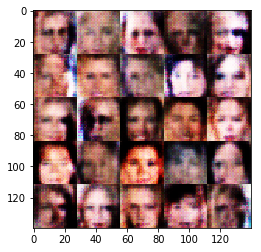

Step 705/32 Epoch 1/1... Discriminator Loss: 1.7015... Generator Loss: 0.4327
Step 710/32 Epoch 1/1... Discriminator Loss: 1.0352... Generator Loss: 2.3346
Step 715/32 Epoch 1/1... Discriminator Loss: 0.5829... Generator Loss: 2.0188
Step 720/32 Epoch 1/1... Discriminator Loss: 0.6538... Generator Loss: 2.2743
Step 725/32 Epoch 1/1... Discriminator Loss: 2.4210... Generator Loss: 0.1887
Step 730/32 Epoch 1/1... Discriminator Loss: 1.0974... Generator Loss: 1.8917
Step 735/32 Epoch 1/1... Discriminator Loss: 1.1932... Generator Loss: 0.6314
Step 740/32 Epoch 1/1... Discriminator Loss: 1.7018... Generator Loss: 1.8915
Step 745/32 Epoch 1/1... Discriminator Loss: 0.7883... Generator Loss: 1.2473
Step 750/32 Epoch 1/1... Discriminator Loss: 0.5190... Generator Loss: 2.6223
Step 755/32 Epoch 1/1... Discriminator Loss: 0.6249... Generator Loss: 2.8474
Step 760/32 Epoch 1/1... Discriminator Loss: 0.5801... Generator Loss: 2.3331
Step 765/32 Epoch 1/1... Discriminator Loss: 0.6729... Generator

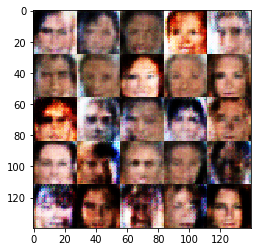

Step 805/32 Epoch 1/1... Discriminator Loss: 1.2206... Generator Loss: 0.6515
Step 810/32 Epoch 1/1... Discriminator Loss: 0.8365... Generator Loss: 1.2401
Step 815/32 Epoch 1/1... Discriminator Loss: 1.2965... Generator Loss: 0.6689
Step 820/32 Epoch 1/1... Discriminator Loss: 0.6721... Generator Loss: 2.7134
Step 825/32 Epoch 1/1... Discriminator Loss: 1.4793... Generator Loss: 0.4511
Step 830/32 Epoch 1/1... Discriminator Loss: 1.0015... Generator Loss: 1.2636
Step 835/32 Epoch 1/1... Discriminator Loss: 1.4413... Generator Loss: 0.5978
Step 840/32 Epoch 1/1... Discriminator Loss: 0.9213... Generator Loss: 1.8787
Step 845/32 Epoch 1/1... Discriminator Loss: 1.2653... Generator Loss: 0.6151
Step 850/32 Epoch 1/1... Discriminator Loss: 0.7191... Generator Loss: 2.5549
Step 855/32 Epoch 1/1... Discriminator Loss: 0.8471... Generator Loss: 1.3320
Step 860/32 Epoch 1/1... Discriminator Loss: 0.7695... Generator Loss: 1.6645
Step 865/32 Epoch 1/1... Discriminator Loss: 0.8045... Generator

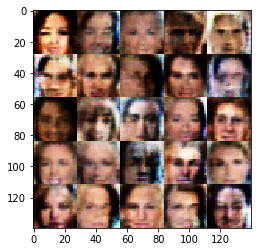

Step 905/32 Epoch 1/1... Discriminator Loss: 0.8369... Generator Loss: 2.1257
Step 910/32 Epoch 1/1... Discriminator Loss: 1.2706... Generator Loss: 0.6180
Step 915/32 Epoch 1/1... Discriminator Loss: 0.7281... Generator Loss: 3.1564
Step 920/32 Epoch 1/1... Discriminator Loss: 0.9673... Generator Loss: 0.8385
Step 925/32 Epoch 1/1... Discriminator Loss: 1.0830... Generator Loss: 2.3553
Step 930/32 Epoch 1/1... Discriminator Loss: 0.9779... Generator Loss: 0.9623
Step 935/32 Epoch 1/1... Discriminator Loss: 0.9075... Generator Loss: 2.0458
Step 940/32 Epoch 1/1... Discriminator Loss: 0.9229... Generator Loss: 1.1468
Step 945/32 Epoch 1/1... Discriminator Loss: 0.8008... Generator Loss: 2.6714
Step 950/32 Epoch 1/1... Discriminator Loss: 1.3838... Generator Loss: 0.4683
Step 955/32 Epoch 1/1... Discriminator Loss: 1.2135... Generator Loss: 2.9762
Step 960/32 Epoch 1/1... Discriminator Loss: 1.4707... Generator Loss: 0.4935
Step 965/32 Epoch 1/1... Discriminator Loss: 0.9101... Generator

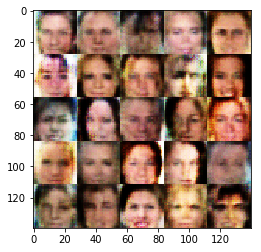

Step 1005/32 Epoch 1/1... Discriminator Loss: 1.1117... Generator Loss: 0.8442
Step 1010/32 Epoch 1/1... Discriminator Loss: 1.0728... Generator Loss: 2.4568
Step 1015/32 Epoch 1/1... Discriminator Loss: 1.0212... Generator Loss: 0.8904
Step 1020/32 Epoch 1/1... Discriminator Loss: 0.8136... Generator Loss: 1.5454
Step 1025/32 Epoch 1/1... Discriminator Loss: 1.3045... Generator Loss: 0.5855
Step 1030/32 Epoch 1/1... Discriminator Loss: 0.9870... Generator Loss: 2.2957
Step 1035/32 Epoch 1/1... Discriminator Loss: 0.9332... Generator Loss: 0.9616
Step 1040/32 Epoch 1/1... Discriminator Loss: 0.6630... Generator Loss: 2.0589
Step 1045/32 Epoch 1/1... Discriminator Loss: 1.4429... Generator Loss: 0.5020
Step 1050/32 Epoch 1/1... Discriminator Loss: 1.4575... Generator Loss: 2.3702
Step 1055/32 Epoch 1/1... Discriminator Loss: 0.8554... Generator Loss: 1.4450
Step 1060/32 Epoch 1/1... Discriminator Loss: 0.7168... Generator Loss: 3.1001
Step 1065/32 Epoch 1/1... Discriminator Loss: 1.1377

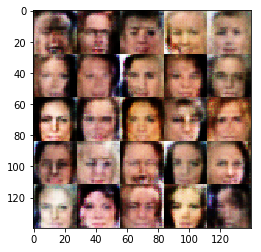

Step 1105/32 Epoch 1/1... Discriminator Loss: 1.5038... Generator Loss: 0.4591
Step 1110/32 Epoch 1/1... Discriminator Loss: 0.5243... Generator Loss: 2.5502
Step 1115/32 Epoch 1/1... Discriminator Loss: 1.9506... Generator Loss: 0.3398
Step 1120/32 Epoch 1/1... Discriminator Loss: 0.9432... Generator Loss: 1.0059
Step 1125/32 Epoch 1/1... Discriminator Loss: 0.7976... Generator Loss: 1.9590
Step 1130/32 Epoch 1/1... Discriminator Loss: 2.7283... Generator Loss: 0.1556
Step 1135/32 Epoch 1/1... Discriminator Loss: 1.2187... Generator Loss: 0.6736
Step 1140/32 Epoch 1/1... Discriminator Loss: 0.9697... Generator Loss: 2.2525
Step 1145/32 Epoch 1/1... Discriminator Loss: 1.4445... Generator Loss: 0.5541
Step 1150/32 Epoch 1/1... Discriminator Loss: 0.9181... Generator Loss: 1.0993
Step 1155/32 Epoch 1/1... Discriminator Loss: 0.9619... Generator Loss: 0.9208
Step 1160/32 Epoch 1/1... Discriminator Loss: 0.6622... Generator Loss: 1.7010
Step 1165/32 Epoch 1/1... Discriminator Loss: 0.9266

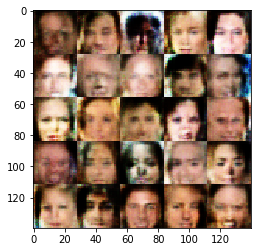

Step 1205/32 Epoch 1/1... Discriminator Loss: 1.9108... Generator Loss: 0.2710
Step 1210/32 Epoch 1/1... Discriminator Loss: 0.8269... Generator Loss: 1.3471
Step 1215/32 Epoch 1/1... Discriminator Loss: 0.7267... Generator Loss: 3.3573
Step 1220/32 Epoch 1/1... Discriminator Loss: 1.8690... Generator Loss: 0.3097
Step 1225/32 Epoch 1/1... Discriminator Loss: 0.9040... Generator Loss: 1.0284
Step 1230/32 Epoch 1/1... Discriminator Loss: 0.7101... Generator Loss: 1.8145
Step 1235/32 Epoch 1/1... Discriminator Loss: 0.9397... Generator Loss: 1.1031
Step 1240/32 Epoch 1/1... Discriminator Loss: 0.5698... Generator Loss: 2.3705
Step 1245/32 Epoch 1/1... Discriminator Loss: 1.5342... Generator Loss: 0.4718
Step 1250/32 Epoch 1/1... Discriminator Loss: 1.4999... Generator Loss: 1.7450
Step 1255/32 Epoch 1/1... Discriminator Loss: 1.1190... Generator Loss: 0.8409
Step 1260/32 Epoch 1/1... Discriminator Loss: 0.7668... Generator Loss: 2.6352
Step 1265/32 Epoch 1/1... Discriminator Loss: 0.6811

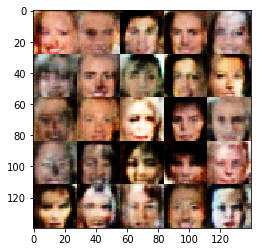

Step 1305/32 Epoch 1/1... Discriminator Loss: 1.1793... Generator Loss: 0.7030
Step 1310/32 Epoch 1/1... Discriminator Loss: 0.6309... Generator Loss: 1.7179
Step 1315/32 Epoch 1/1... Discriminator Loss: 0.6654... Generator Loss: 1.5466
Step 1320/32 Epoch 1/1... Discriminator Loss: 0.7997... Generator Loss: 2.6598
Step 1325/32 Epoch 1/1... Discriminator Loss: 2.3127... Generator Loss: 0.1770
Step 1330/32 Epoch 1/1... Discriminator Loss: 0.7468... Generator Loss: 1.4947
Step 1335/32 Epoch 1/1... Discriminator Loss: 0.5269... Generator Loss: 2.6415
Step 1340/32 Epoch 1/1... Discriminator Loss: 1.1882... Generator Loss: 0.6566
Step 1345/32 Epoch 1/1... Discriminator Loss: 1.4391... Generator Loss: 0.5476
Step 1350/32 Epoch 1/1... Discriminator Loss: 0.8150... Generator Loss: 1.2154
Step 1355/32 Epoch 1/1... Discriminator Loss: 0.6139... Generator Loss: 2.6345
Step 1360/32 Epoch 1/1... Discriminator Loss: 1.4657... Generator Loss: 0.5105
Step 1365/32 Epoch 1/1... Discriminator Loss: 1.0265

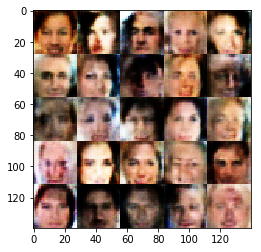

Step 1405/32 Epoch 1/1... Discriminator Loss: 1.0094... Generator Loss: 2.7610
Step 1410/32 Epoch 1/1... Discriminator Loss: 1.2432... Generator Loss: 0.6523
Step 1415/32 Epoch 1/1... Discriminator Loss: 0.4736... Generator Loss: 2.6595
Step 1420/32 Epoch 1/1... Discriminator Loss: 0.7109... Generator Loss: 1.3020
Step 1425/32 Epoch 1/1... Discriminator Loss: 0.7461... Generator Loss: 1.5725
Step 1430/32 Epoch 1/1... Discriminator Loss: 0.6475... Generator Loss: 3.5895
Step 1435/32 Epoch 1/1... Discriminator Loss: 1.1789... Generator Loss: 0.8849
Step 1440/32 Epoch 1/1... Discriminator Loss: 2.5204... Generator Loss: 1.1299
Step 1445/32 Epoch 1/1... Discriminator Loss: 1.4758... Generator Loss: 0.4205
Step 1450/32 Epoch 1/1... Discriminator Loss: 0.8820... Generator Loss: 2.7434
Step 1455/32 Epoch 1/1... Discriminator Loss: 0.8249... Generator Loss: 1.1198
Step 1460/32 Epoch 1/1... Discriminator Loss: 0.6812... Generator Loss: 1.7076
Step 1465/32 Epoch 1/1... Discriminator Loss: 0.5530

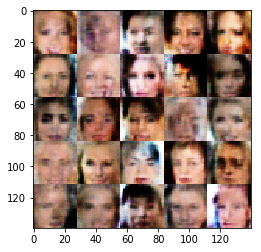

Step 1505/32 Epoch 1/1... Discriminator Loss: 1.2342... Generator Loss: 0.9478
Step 1510/32 Epoch 1/1... Discriminator Loss: 0.7553... Generator Loss: 1.1699
Step 1515/32 Epoch 1/1... Discriminator Loss: 0.6461... Generator Loss: 2.2425
Step 1520/32 Epoch 1/1... Discriminator Loss: 0.5651... Generator Loss: 2.5242
Step 1525/32 Epoch 1/1... Discriminator Loss: 1.0212... Generator Loss: 0.9993
Step 1530/32 Epoch 1/1... Discriminator Loss: 0.8485... Generator Loss: 4.4914
Step 1535/32 Epoch 1/1... Discriminator Loss: 0.6836... Generator Loss: 1.7610
Step 1540/32 Epoch 1/1... Discriminator Loss: 0.5397... Generator Loss: 2.3349
Step 1545/32 Epoch 1/1... Discriminator Loss: 0.7290... Generator Loss: 1.4150
Step 1550/32 Epoch 1/1... Discriminator Loss: 1.7842... Generator Loss: 0.3714
Step 1555/32 Epoch 1/1... Discriminator Loss: 1.5480... Generator Loss: 0.4350
Step 1560/32 Epoch 1/1... Discriminator Loss: 0.5150... Generator Loss: 3.4274
Step 1565/32 Epoch 1/1... Discriminator Loss: 1.3667

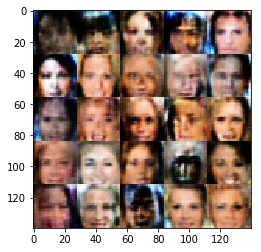

Step 1605/32 Epoch 1/1... Discriminator Loss: 0.6326... Generator Loss: 2.6861
Step 1610/32 Epoch 1/1... Discriminator Loss: 0.6562... Generator Loss: 1.8272
Step 1615/32 Epoch 1/1... Discriminator Loss: 0.4699... Generator Loss: 3.5454
Step 1620/32 Epoch 1/1... Discriminator Loss: 1.6009... Generator Loss: 0.3561
Step 1625/32 Epoch 1/1... Discriminator Loss: 0.5431... Generator Loss: 2.1846
Step 1630/32 Epoch 1/1... Discriminator Loss: 0.9734... Generator Loss: 1.0275
Step 1635/32 Epoch 1/1... Discriminator Loss: 0.6536... Generator Loss: 2.9609
Step 1640/32 Epoch 1/1... Discriminator Loss: 0.8996... Generator Loss: 1.1710
Step 1645/32 Epoch 1/1... Discriminator Loss: 2.5819... Generator Loss: 0.1340
Step 1650/32 Epoch 1/1... Discriminator Loss: 0.5624... Generator Loss: 2.5698
Step 1655/32 Epoch 1/1... Discriminator Loss: 1.4179... Generator Loss: 0.6397
Step 1660/32 Epoch 1/1... Discriminator Loss: 1.0148... Generator Loss: 4.2752
Step 1665/32 Epoch 1/1... Discriminator Loss: 0.5614

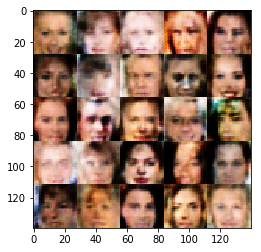

Step 1705/32 Epoch 1/1... Discriminator Loss: 0.9046... Generator Loss: 1.1161
Step 1710/32 Epoch 1/1... Discriminator Loss: 0.5246... Generator Loss: 2.9233
Step 1715/32 Epoch 1/1... Discriminator Loss: 1.1698... Generator Loss: 0.7992
Step 1720/32 Epoch 1/1... Discriminator Loss: 0.5195... Generator Loss: 2.8423
Step 1725/32 Epoch 1/1... Discriminator Loss: 1.3138... Generator Loss: 0.5073
Step 1730/32 Epoch 1/1... Discriminator Loss: 0.5021... Generator Loss: 2.5399
Step 1735/32 Epoch 1/1... Discriminator Loss: 0.9937... Generator Loss: 0.7742
Step 1740/32 Epoch 1/1... Discriminator Loss: 0.4946... Generator Loss: 2.3811
Step 1745/32 Epoch 1/1... Discriminator Loss: 1.1744... Generator Loss: 0.7208
Step 1750/32 Epoch 1/1... Discriminator Loss: 1.2809... Generator Loss: 0.9436
Step 1755/32 Epoch 1/1... Discriminator Loss: 0.6716... Generator Loss: 1.5413
Step 1760/32 Epoch 1/1... Discriminator Loss: 0.5706... Generator Loss: 4.1207
Step 1765/32 Epoch 1/1... Discriminator Loss: 0.9103

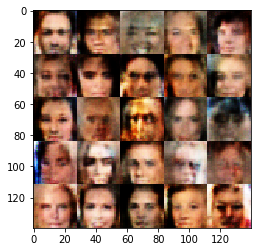

Step 1805/32 Epoch 1/1... Discriminator Loss: 1.1712... Generator Loss: 0.7892
Step 1810/32 Epoch 1/1... Discriminator Loss: 0.7418... Generator Loss: 3.5730
Step 1815/32 Epoch 1/1... Discriminator Loss: 1.3513... Generator Loss: 0.7116
Step 1820/32 Epoch 1/1... Discriminator Loss: 0.8050... Generator Loss: 4.3246
Step 1825/32 Epoch 1/1... Discriminator Loss: 0.4877... Generator Loss: 4.1421
Step 1830/32 Epoch 1/1... Discriminator Loss: 0.4581... Generator Loss: 3.1410
Step 1835/32 Epoch 1/1... Discriminator Loss: 1.8345... Generator Loss: 0.3296
Step 1840/32 Epoch 1/1... Discriminator Loss: 0.5386... Generator Loss: 2.7854
Step 1845/32 Epoch 1/1... Discriminator Loss: 0.6477... Generator Loss: 1.9045
Step 1850/32 Epoch 1/1... Discriminator Loss: 0.6265... Generator Loss: 1.5307
Step 1855/32 Epoch 1/1... Discriminator Loss: 0.5464... Generator Loss: 2.2141
Step 1860/32 Epoch 1/1... Discriminator Loss: 0.4841... Generator Loss: 2.3380
Step 1865/32 Epoch 1/1... Discriminator Loss: 0.4432

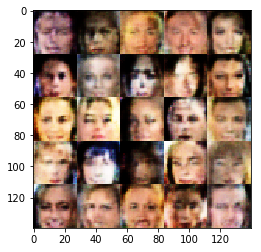

Step 1905/32 Epoch 1/1... Discriminator Loss: 0.6429... Generator Loss: 3.3706
Step 1910/32 Epoch 1/1... Discriminator Loss: 0.9605... Generator Loss: 0.8721
Step 1915/32 Epoch 1/1... Discriminator Loss: 0.5993... Generator Loss: 2.7349
Step 1920/32 Epoch 1/1... Discriminator Loss: 0.5613... Generator Loss: 4.7394
Step 1925/32 Epoch 1/1... Discriminator Loss: 1.0471... Generator Loss: 1.5132
Step 1930/32 Epoch 1/1... Discriminator Loss: 0.5942... Generator Loss: 2.0125
Step 1935/32 Epoch 1/1... Discriminator Loss: 0.4892... Generator Loss: 2.9444
Step 1940/32 Epoch 1/1... Discriminator Loss: 0.7542... Generator Loss: 1.2072
Step 1945/32 Epoch 1/1... Discriminator Loss: 0.7741... Generator Loss: 1.2534
Step 1950/32 Epoch 1/1... Discriminator Loss: 0.6834... Generator Loss: 1.9784
Step 1955/32 Epoch 1/1... Discriminator Loss: 0.5272... Generator Loss: 2.1253
Step 1960/32 Epoch 1/1... Discriminator Loss: 0.4990... Generator Loss: 2.8097
Step 1965/32 Epoch 1/1... Discriminator Loss: 0.7936

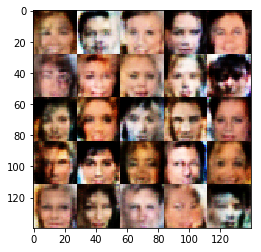

Step 2005/32 Epoch 1/1... Discriminator Loss: 0.7130... Generator Loss: 1.5409
Step 2010/32 Epoch 1/1... Discriminator Loss: 0.5719... Generator Loss: 2.5994
Step 2015/32 Epoch 1/1... Discriminator Loss: 0.6534... Generator Loss: 1.9183
Step 2020/32 Epoch 1/1... Discriminator Loss: 0.6189... Generator Loss: 1.6867
Step 2025/32 Epoch 1/1... Discriminator Loss: 0.5635... Generator Loss: 3.0623
Step 2030/32 Epoch 1/1... Discriminator Loss: 2.5756... Generator Loss: 2.0159
Step 2035/32 Epoch 1/1... Discriminator Loss: 0.9197... Generator Loss: 0.9102
Step 2040/32 Epoch 1/1... Discriminator Loss: 0.8192... Generator Loss: 2.0610
Step 2045/32 Epoch 1/1... Discriminator Loss: 0.4151... Generator Loss: 3.8610
Step 2050/32 Epoch 1/1... Discriminator Loss: 0.5655... Generator Loss: 1.9696
Step 2055/32 Epoch 1/1... Discriminator Loss: 0.7297... Generator Loss: 3.6420
Step 2060/32 Epoch 1/1... Discriminator Loss: 0.5521... Generator Loss: 3.1073
Step 2065/32 Epoch 1/1... Discriminator Loss: 0.4896

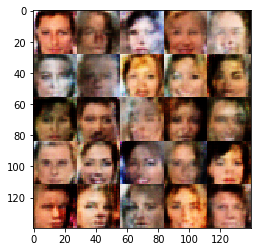

Step 2105/32 Epoch 1/1... Discriminator Loss: 0.5013... Generator Loss: 3.0912
Step 2110/32 Epoch 1/1... Discriminator Loss: 1.1908... Generator Loss: 0.8165
Step 2115/32 Epoch 1/1... Discriminator Loss: 0.9777... Generator Loss: 2.0893
Step 2120/32 Epoch 1/1... Discriminator Loss: 0.5576... Generator Loss: 2.0272
Step 2125/32 Epoch 1/1... Discriminator Loss: 0.9984... Generator Loss: 1.7816
Step 2130/32 Epoch 1/1... Discriminator Loss: 0.5757... Generator Loss: 3.3903
Step 2135/32 Epoch 1/1... Discriminator Loss: 0.8453... Generator Loss: 1.3681
Step 2140/32 Epoch 1/1... Discriminator Loss: 1.0767... Generator Loss: 1.8577
Step 2145/32 Epoch 1/1... Discriminator Loss: 1.0888... Generator Loss: 0.8651
Step 2150/32 Epoch 1/1... Discriminator Loss: 1.7237... Generator Loss: 0.3601
Step 2155/32 Epoch 1/1... Discriminator Loss: 1.7269... Generator Loss: 2.2096
Step 2160/32 Epoch 1/1... Discriminator Loss: 0.5901... Generator Loss: 2.3335
Step 2165/32 Epoch 1/1... Discriminator Loss: 1.3682

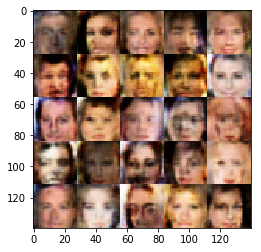

Step 2205/32 Epoch 1/1... Discriminator Loss: 1.2473... Generator Loss: 1.6633
Step 2210/32 Epoch 1/1... Discriminator Loss: 0.9989... Generator Loss: 2.0903
Step 2215/32 Epoch 1/1... Discriminator Loss: 0.7197... Generator Loss: 1.4365
Step 2220/32 Epoch 1/1... Discriminator Loss: 0.5721... Generator Loss: 2.7150
Step 2225/32 Epoch 1/1... Discriminator Loss: 0.5403... Generator Loss: 3.5908
Step 2230/32 Epoch 1/1... Discriminator Loss: 0.5823... Generator Loss: 1.9195
Step 2235/32 Epoch 1/1... Discriminator Loss: 0.5791... Generator Loss: 1.7615
Step 2240/32 Epoch 1/1... Discriminator Loss: 1.0188... Generator Loss: 0.7345
Step 2245/32 Epoch 1/1... Discriminator Loss: 0.4510... Generator Loss: 3.3238
Step 2250/32 Epoch 1/1... Discriminator Loss: 0.5734... Generator Loss: 2.3474
Step 2255/32 Epoch 1/1... Discriminator Loss: 1.2233... Generator Loss: 0.7153
Step 2260/32 Epoch 1/1... Discriminator Loss: 1.3335... Generator Loss: 0.9426
Step 2265/32 Epoch 1/1... Discriminator Loss: 0.8180

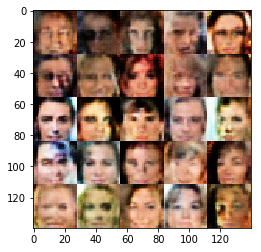

Step 2305/32 Epoch 1/1... Discriminator Loss: 0.9756... Generator Loss: 2.4799
Step 2310/32 Epoch 1/1... Discriminator Loss: 0.6572... Generator Loss: 2.9056
Step 2315/32 Epoch 1/1... Discriminator Loss: 0.9523... Generator Loss: 1.0659
Step 2320/32 Epoch 1/1... Discriminator Loss: 0.7660... Generator Loss: 2.2662
Step 2325/32 Epoch 1/1... Discriminator Loss: 0.8266... Generator Loss: 1.2006
Step 2330/32 Epoch 1/1... Discriminator Loss: 0.5433... Generator Loss: 2.2291
Step 2335/32 Epoch 1/1... Discriminator Loss: 0.4845... Generator Loss: 3.8016
Step 2340/32 Epoch 1/1... Discriminator Loss: 1.4222... Generator Loss: 0.7837
Step 2345/32 Epoch 1/1... Discriminator Loss: 0.5600... Generator Loss: 2.3496
Step 2350/32 Epoch 1/1... Discriminator Loss: 0.8149... Generator Loss: 1.1538
Step 2355/32 Epoch 1/1... Discriminator Loss: 0.6598... Generator Loss: 1.5289
Step 2360/32 Epoch 1/1... Discriminator Loss: 0.6016... Generator Loss: 2.2410
Step 2365/32 Epoch 1/1... Discriminator Loss: 0.5686

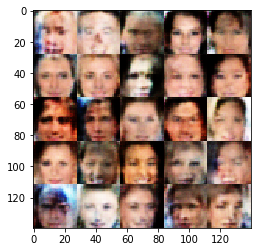

Step 2405/32 Epoch 1/1... Discriminator Loss: 0.5836... Generator Loss: 3.3700
Step 2410/32 Epoch 1/1... Discriminator Loss: 2.7285... Generator Loss: 1.7842
Step 2415/32 Epoch 1/1... Discriminator Loss: 1.0323... Generator Loss: 0.8839
Step 2420/32 Epoch 1/1... Discriminator Loss: 0.8798... Generator Loss: 1.8577
Step 2425/32 Epoch 1/1... Discriminator Loss: 1.0085... Generator Loss: 0.7787
Step 2430/32 Epoch 1/1... Discriminator Loss: 0.6746... Generator Loss: 1.8866
Step 2435/32 Epoch 1/1... Discriminator Loss: 0.6706... Generator Loss: 1.4980
Step 2440/32 Epoch 1/1... Discriminator Loss: 2.8713... Generator Loss: 0.1152
Step 2445/32 Epoch 1/1... Discriminator Loss: 0.5984... Generator Loss: 2.9306
Step 2450/32 Epoch 1/1... Discriminator Loss: 0.5085... Generator Loss: 2.2258
Step 2455/32 Epoch 1/1... Discriminator Loss: 0.9256... Generator Loss: 1.1020
Step 2460/32 Epoch 1/1... Discriminator Loss: 0.6544... Generator Loss: 1.8168
Step 2465/32 Epoch 1/1... Discriminator Loss: 0.5974

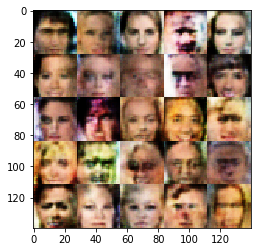

Step 2505/32 Epoch 1/1... Discriminator Loss: 0.6411... Generator Loss: 1.6632
Step 2510/32 Epoch 1/1... Discriminator Loss: 0.7845... Generator Loss: 1.3379
Step 2515/32 Epoch 1/1... Discriminator Loss: 0.5828... Generator Loss: 2.0990
Step 2520/32 Epoch 1/1... Discriminator Loss: 1.3666... Generator Loss: 2.3486
Step 2525/32 Epoch 1/1... Discriminator Loss: 0.8306... Generator Loss: 1.2347
Step 2530/32 Epoch 1/1... Discriminator Loss: 0.6862... Generator Loss: 1.5539
Step 2535/32 Epoch 1/1... Discriminator Loss: 0.8451... Generator Loss: 1.2412
Step 2540/32 Epoch 1/1... Discriminator Loss: 0.6911... Generator Loss: 1.4711
Step 2545/32 Epoch 1/1... Discriminator Loss: 0.7496... Generator Loss: 1.4889
Step 2550/32 Epoch 1/1... Discriminator Loss: 1.1822... Generator Loss: 1.1899
Step 2555/32 Epoch 1/1... Discriminator Loss: 0.8334... Generator Loss: 1.3949
Step 2560/32 Epoch 1/1... Discriminator Loss: 0.6305... Generator Loss: 1.6304
Step 2565/32 Epoch 1/1... Discriminator Loss: 0.4745

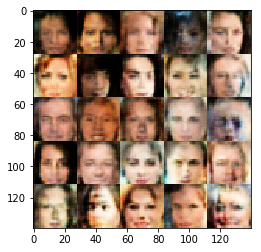

Step 2605/32 Epoch 1/1... Discriminator Loss: 0.5533... Generator Loss: 2.3246
Step 2610/32 Epoch 1/1... Discriminator Loss: 0.8658... Generator Loss: 1.1843
Step 2615/32 Epoch 1/1... Discriminator Loss: 1.4336... Generator Loss: 0.4417
Step 2620/32 Epoch 1/1... Discriminator Loss: 3.2194... Generator Loss: 0.0829
Step 2625/32 Epoch 1/1... Discriminator Loss: 0.9870... Generator Loss: 0.8435
Step 2630/32 Epoch 1/1... Discriminator Loss: 0.4924... Generator Loss: 2.9533
Step 2635/32 Epoch 1/1... Discriminator Loss: 1.0622... Generator Loss: 0.8414
Step 2640/32 Epoch 1/1... Discriminator Loss: 0.4193... Generator Loss: 3.7383
Step 2645/32 Epoch 1/1... Discriminator Loss: 0.9319... Generator Loss: 2.3496
Step 2650/32 Epoch 1/1... Discriminator Loss: 0.9298... Generator Loss: 0.9978
Step 2655/32 Epoch 1/1... Discriminator Loss: 0.9398... Generator Loss: 1.6656
Step 2660/32 Epoch 1/1... Discriminator Loss: 0.6041... Generator Loss: 1.8054
Step 2665/32 Epoch 1/1... Discriminator Loss: 0.5068

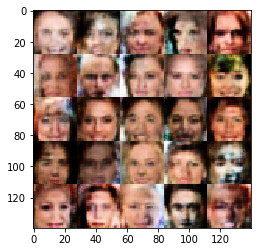

Step 2705/32 Epoch 1/1... Discriminator Loss: 1.4778... Generator Loss: 0.4727
Step 2710/32 Epoch 1/1... Discriminator Loss: 0.8886... Generator Loss: 1.0716
Step 2715/32 Epoch 1/1... Discriminator Loss: 1.4524... Generator Loss: 0.6948
Step 2720/32 Epoch 1/1... Discriminator Loss: 0.4869... Generator Loss: 2.4102
Step 2725/32 Epoch 1/1... Discriminator Loss: 0.4900... Generator Loss: 2.6957
Step 2730/32 Epoch 1/1... Discriminator Loss: 0.6326... Generator Loss: 1.8241
Step 2735/32 Epoch 1/1... Discriminator Loss: 0.9094... Generator Loss: 1.0758
Step 2740/32 Epoch 1/1... Discriminator Loss: 0.8881... Generator Loss: 1.3405
Step 2745/32 Epoch 1/1... Discriminator Loss: 0.5309... Generator Loss: 3.1896
Step 2750/32 Epoch 1/1... Discriminator Loss: 1.4211... Generator Loss: 0.5336
Step 2755/32 Epoch 1/1... Discriminator Loss: 1.5446... Generator Loss: 2.0828
Step 2760/32 Epoch 1/1... Discriminator Loss: 2.0024... Generator Loss: 0.2673
Step 2765/32 Epoch 1/1... Discriminator Loss: 0.8080

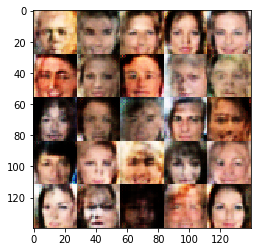

Step 2805/32 Epoch 1/1... Discriminator Loss: 0.4146... Generator Loss: 3.1125
Step 2810/32 Epoch 1/1... Discriminator Loss: 1.1632... Generator Loss: 0.6077
Step 2815/32 Epoch 1/1... Discriminator Loss: 1.2718... Generator Loss: 0.6738
Step 2820/32 Epoch 1/1... Discriminator Loss: 0.6948... Generator Loss: 1.6297
Step 2825/32 Epoch 1/1... Discriminator Loss: 0.6029... Generator Loss: 1.7000
Step 2830/32 Epoch 1/1... Discriminator Loss: 1.0189... Generator Loss: 2.6393
Step 2835/32 Epoch 1/1... Discriminator Loss: 0.8132... Generator Loss: 2.9429
Step 2840/32 Epoch 1/1... Discriminator Loss: 1.7888... Generator Loss: 1.9794
Step 2845/32 Epoch 1/1... Discriminator Loss: 0.6115... Generator Loss: 3.5114
Step 2850/32 Epoch 1/1... Discriminator Loss: 0.9485... Generator Loss: 2.3432
Step 2855/32 Epoch 1/1... Discriminator Loss: 0.6196... Generator Loss: 2.0250
Step 2860/32 Epoch 1/1... Discriminator Loss: 0.4488... Generator Loss: 3.3694
Step 2865/32 Epoch 1/1... Discriminator Loss: 0.6203

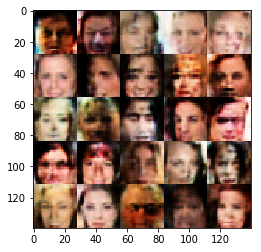

Step 2905/32 Epoch 1/1... Discriminator Loss: 0.9907... Generator Loss: 0.7962
Step 2910/32 Epoch 1/1... Discriminator Loss: 0.6149... Generator Loss: 1.5849
Step 2915/32 Epoch 1/1... Discriminator Loss: 0.7084... Generator Loss: 1.3026
Step 2920/32 Epoch 1/1... Discriminator Loss: 0.5138... Generator Loss: 2.3292
Step 2925/32 Epoch 1/1... Discriminator Loss: 0.7303... Generator Loss: 1.4605
Step 2930/32 Epoch 1/1... Discriminator Loss: 0.9831... Generator Loss: 1.2314
Step 2935/32 Epoch 1/1... Discriminator Loss: 0.9760... Generator Loss: 1.3230
Step 2940/32 Epoch 1/1... Discriminator Loss: 0.4751... Generator Loss: 2.9999
Step 2945/32 Epoch 1/1... Discriminator Loss: 0.5402... Generator Loss: 2.1580
Step 2950/32 Epoch 1/1... Discriminator Loss: 2.2621... Generator Loss: 3.0103
Step 2955/32 Epoch 1/1... Discriminator Loss: 0.7873... Generator Loss: 3.0748
Step 2960/32 Epoch 1/1... Discriminator Loss: 0.6393... Generator Loss: 1.5899
Step 2965/32 Epoch 1/1... Discriminator Loss: 0.7840

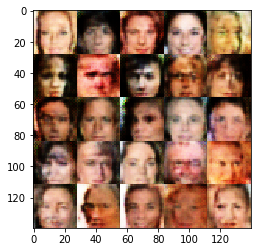

Step 3005/32 Epoch 1/1... Discriminator Loss: 0.5544... Generator Loss: 1.9665
Step 3010/32 Epoch 1/1... Discriminator Loss: 0.4836... Generator Loss: 3.1492
Step 3015/32 Epoch 1/1... Discriminator Loss: 1.1879... Generator Loss: 1.2832
Step 3020/32 Epoch 1/1... Discriminator Loss: 0.9464... Generator Loss: 2.4237
Step 3025/32 Epoch 1/1... Discriminator Loss: 0.8118... Generator Loss: 1.5266
Step 3030/32 Epoch 1/1... Discriminator Loss: 0.9108... Generator Loss: 1.0477
Step 3035/32 Epoch 1/1... Discriminator Loss: 1.0829... Generator Loss: 0.8070
Step 3040/32 Epoch 1/1... Discriminator Loss: 1.7811... Generator Loss: 0.3376
Step 3045/32 Epoch 1/1... Discriminator Loss: 0.5658... Generator Loss: 1.9565
Step 3050/32 Epoch 1/1... Discriminator Loss: 0.4452... Generator Loss: 3.2862
Step 3055/32 Epoch 1/1... Discriminator Loss: 0.5975... Generator Loss: 1.8751
Step 3060/32 Epoch 1/1... Discriminator Loss: 0.5145... Generator Loss: 2.8546
Step 3065/32 Epoch 1/1... Discriminator Loss: 1.5291

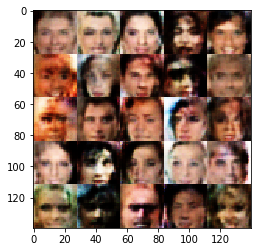

Step 3105/32 Epoch 1/1... Discriminator Loss: 0.5235... Generator Loss: 3.3998
Step 3110/32 Epoch 1/1... Discriminator Loss: 1.4191... Generator Loss: 0.6952
Step 3115/32 Epoch 1/1... Discriminator Loss: 0.6379... Generator Loss: 1.8749
Step 3120/32 Epoch 1/1... Discriminator Loss: 0.8272... Generator Loss: 1.4640
Step 3125/32 Epoch 1/1... Discriminator Loss: 0.8379... Generator Loss: 1.1749
Step 3130/32 Epoch 1/1... Discriminator Loss: 0.5896... Generator Loss: 1.8885
Step 3135/32 Epoch 1/1... Discriminator Loss: 0.4579... Generator Loss: 2.9386
Step 3140/32 Epoch 1/1... Discriminator Loss: 1.0139... Generator Loss: 1.1502
Step 3145/32 Epoch 1/1... Discriminator Loss: 1.3525... Generator Loss: 0.5636
Step 3150/32 Epoch 1/1... Discriminator Loss: 0.7493... Generator Loss: 1.4723
Step 3155/32 Epoch 1/1... Discriminator Loss: 0.4432... Generator Loss: 4.5776
Step 3160/32 Epoch 1/1... Discriminator Loss: 0.4498... Generator Loss: 4.2543
Step 3165/32 Epoch 1/1... Discriminator Loss: 1.0464

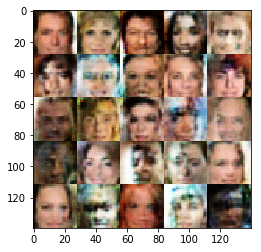

Step 3205/32 Epoch 1/1... Discriminator Loss: 0.6429... Generator Loss: 1.6846
Step 3210/32 Epoch 1/1... Discriminator Loss: 1.0181... Generator Loss: 1.5018
Step 3215/32 Epoch 1/1... Discriminator Loss: 1.3302... Generator Loss: 0.5118
Step 3220/32 Epoch 1/1... Discriminator Loss: 1.0242... Generator Loss: 0.7718
Step 3225/32 Epoch 1/1... Discriminator Loss: 0.4952... Generator Loss: 2.2256
Step 3230/32 Epoch 1/1... Discriminator Loss: 0.6342... Generator Loss: 2.5548
Step 3235/32 Epoch 1/1... Discriminator Loss: 0.9189... Generator Loss: 0.9128
Step 3240/32 Epoch 1/1... Discriminator Loss: 0.7740... Generator Loss: 3.4686
Step 3245/32 Epoch 1/1... Discriminator Loss: 1.4720... Generator Loss: 0.9476
Step 3250/32 Epoch 1/1... Discriminator Loss: 0.6981... Generator Loss: 4.3312
Step 3255/32 Epoch 1/1... Discriminator Loss: 0.8892... Generator Loss: 1.6110
Step 3260/32 Epoch 1/1... Discriminator Loss: 0.9650... Generator Loss: 0.9179
Step 3265/32 Epoch 1/1... Discriminator Loss: 1.4445

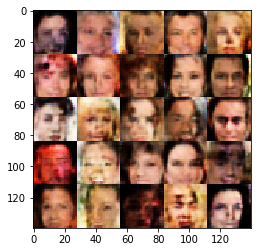

Step 3305/32 Epoch 1/1... Discriminator Loss: 0.7437... Generator Loss: 1.3625
Step 3310/32 Epoch 1/1... Discriminator Loss: 1.2213... Generator Loss: 0.5843
Step 3315/32 Epoch 1/1... Discriminator Loss: 0.5088... Generator Loss: 3.1440
Step 3320/32 Epoch 1/1... Discriminator Loss: 0.4445... Generator Loss: 3.2719
Step 3325/32 Epoch 1/1... Discriminator Loss: 0.7419... Generator Loss: 3.6048
Step 3330/32 Epoch 1/1... Discriminator Loss: 0.5750... Generator Loss: 4.0945
Step 3335/32 Epoch 1/1... Discriminator Loss: 0.8355... Generator Loss: 1.4337
Step 3340/32 Epoch 1/1... Discriminator Loss: 0.5347... Generator Loss: 1.9902
Step 3345/32 Epoch 1/1... Discriminator Loss: 1.0562... Generator Loss: 1.0109
Step 3350/32 Epoch 1/1... Discriminator Loss: 0.4777... Generator Loss: 2.2298
Step 3355/32 Epoch 1/1... Discriminator Loss: 0.4540... Generator Loss: 2.7722
Step 3360/32 Epoch 1/1... Discriminator Loss: 1.2498... Generator Loss: 0.9378
Step 3365/32 Epoch 1/1... Discriminator Loss: 0.4669

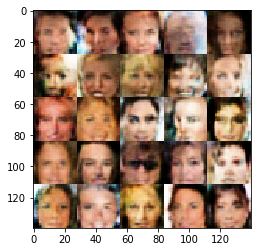

Step 3405/32 Epoch 1/1... Discriminator Loss: 1.4458... Generator Loss: 0.6057
Step 3410/32 Epoch 1/1... Discriminator Loss: 1.8738... Generator Loss: 0.2783
Step 3415/32 Epoch 1/1... Discriminator Loss: 0.5762... Generator Loss: 3.3345
Step 3420/32 Epoch 1/1... Discriminator Loss: 0.9855... Generator Loss: 0.9392
Step 3425/32 Epoch 1/1... Discriminator Loss: 0.6035... Generator Loss: 2.6315
Step 3430/32 Epoch 1/1... Discriminator Loss: 1.0260... Generator Loss: 0.7289
Step 3435/32 Epoch 1/1... Discriminator Loss: 0.7710... Generator Loss: 1.2384
Step 3440/32 Epoch 1/1... Discriminator Loss: 1.1875... Generator Loss: 1.3915
Step 3445/32 Epoch 1/1... Discriminator Loss: 0.7520... Generator Loss: 3.5680
Step 3450/32 Epoch 1/1... Discriminator Loss: 0.6234... Generator Loss: 2.6474
Step 3455/32 Epoch 1/1... Discriminator Loss: 0.5424... Generator Loss: 2.0813
Step 3460/32 Epoch 1/1... Discriminator Loss: 1.3152... Generator Loss: 0.6710
Step 3465/32 Epoch 1/1... Discriminator Loss: 0.4786

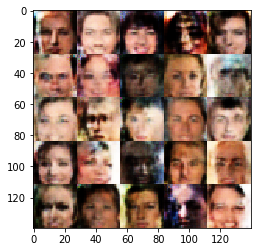

Step 3505/32 Epoch 1/1... Discriminator Loss: 0.9204... Generator Loss: 0.9629
Step 3510/32 Epoch 1/1... Discriminator Loss: 0.4554... Generator Loss: 3.9804
Step 3515/32 Epoch 1/1... Discriminator Loss: 0.5979... Generator Loss: 1.7414
Step 3520/32 Epoch 1/1... Discriminator Loss: 1.0076... Generator Loss: 0.8272
Step 3525/32 Epoch 1/1... Discriminator Loss: 1.1943... Generator Loss: 1.7143
Step 3530/32 Epoch 1/1... Discriminator Loss: 1.0101... Generator Loss: 2.2726
Step 3535/32 Epoch 1/1... Discriminator Loss: 0.6288... Generator Loss: 1.8179
Step 3540/32 Epoch 1/1... Discriminator Loss: 1.3339... Generator Loss: 0.5823
Step 3545/32 Epoch 1/1... Discriminator Loss: 0.4175... Generator Loss: 2.9317
Step 3550/32 Epoch 1/1... Discriminator Loss: 0.9832... Generator Loss: 1.0626
Step 3555/32 Epoch 1/1... Discriminator Loss: 1.8255... Generator Loss: 0.3315
Step 3560/32 Epoch 1/1... Discriminator Loss: 1.3097... Generator Loss: 0.6191
Step 3565/32 Epoch 1/1... Discriminator Loss: 0.6249

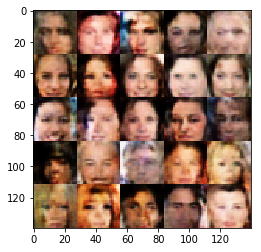

Step 3605/32 Epoch 1/1... Discriminator Loss: 0.7439... Generator Loss: 3.0202
Step 3610/32 Epoch 1/1... Discriminator Loss: 0.4247... Generator Loss: 4.7055
Step 3615/32 Epoch 1/1... Discriminator Loss: 0.6821... Generator Loss: 1.9588
Step 3620/32 Epoch 1/1... Discriminator Loss: 0.4224... Generator Loss: 3.8220
Step 3625/32 Epoch 1/1... Discriminator Loss: 1.1111... Generator Loss: 2.4095
Step 3630/32 Epoch 1/1... Discriminator Loss: 0.9091... Generator Loss: 1.1778
Step 3635/32 Epoch 1/1... Discriminator Loss: 0.4654... Generator Loss: 2.9703
Step 3640/32 Epoch 1/1... Discriminator Loss: 0.5491... Generator Loss: 2.2150
Step 3645/32 Epoch 1/1... Discriminator Loss: 0.4895... Generator Loss: 2.5726
Step 3650/32 Epoch 1/1... Discriminator Loss: 0.6875... Generator Loss: 1.6669
Step 3655/32 Epoch 1/1... Discriminator Loss: 0.5661... Generator Loss: 2.9513
Step 3660/32 Epoch 1/1... Discriminator Loss: 0.6167... Generator Loss: 2.0145
Step 3665/32 Epoch 1/1... Discriminator Loss: 1.7184

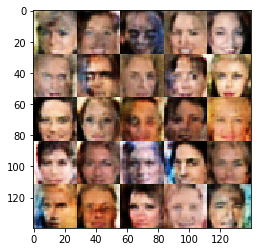

Step 3705/32 Epoch 1/1... Discriminator Loss: 0.4765... Generator Loss: 2.2362
Step 3710/32 Epoch 1/1... Discriminator Loss: 0.4835... Generator Loss: 3.5094
Step 3715/32 Epoch 1/1... Discriminator Loss: 0.5920... Generator Loss: 1.8950
Step 3720/32 Epoch 1/1... Discriminator Loss: 0.4345... Generator Loss: 2.5648
Step 3725/32 Epoch 1/1... Discriminator Loss: 0.7278... Generator Loss: 1.5506
Step 3730/32 Epoch 1/1... Discriminator Loss: 1.0877... Generator Loss: 1.4634
Step 3735/32 Epoch 1/1... Discriminator Loss: 0.9018... Generator Loss: 0.9589
Step 3740/32 Epoch 1/1... Discriminator Loss: 1.2534... Generator Loss: 2.6487
Step 3745/32 Epoch 1/1... Discriminator Loss: 0.8238... Generator Loss: 1.6169
Step 3750/32 Epoch 1/1... Discriminator Loss: 0.7111... Generator Loss: 2.5668
Step 3755/32 Epoch 1/1... Discriminator Loss: 0.6581... Generator Loss: 1.7084
Step 3760/32 Epoch 1/1... Discriminator Loss: 0.4754... Generator Loss: 3.9679
Step 3765/32 Epoch 1/1... Discriminator Loss: 1.1509

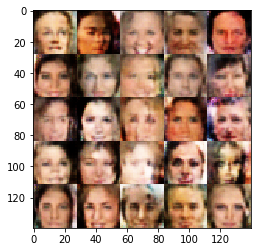

Step 3805/32 Epoch 1/1... Discriminator Loss: 0.5473... Generator Loss: 2.1927
Step 3810/32 Epoch 1/1... Discriminator Loss: 0.5399... Generator Loss: 2.4711
Step 3815/32 Epoch 1/1... Discriminator Loss: 0.5136... Generator Loss: 2.0441
Step 3820/32 Epoch 1/1... Discriminator Loss: 0.4045... Generator Loss: 3.4601
Step 3825/32 Epoch 1/1... Discriminator Loss: 0.7049... Generator Loss: 1.4485
Step 3830/32 Epoch 1/1... Discriminator Loss: 0.8163... Generator Loss: 1.3959
Step 3835/32 Epoch 1/1... Discriminator Loss: 0.4480... Generator Loss: 3.4383
Step 3840/32 Epoch 1/1... Discriminator Loss: 0.8594... Generator Loss: 1.1001
Step 3845/32 Epoch 1/1... Discriminator Loss: 0.4260... Generator Loss: 3.0643
Step 3850/32 Epoch 1/1... Discriminator Loss: 0.5348... Generator Loss: 2.2512
Step 3855/32 Epoch 1/1... Discriminator Loss: 0.9757... Generator Loss: 1.0122
Step 3860/32 Epoch 1/1... Discriminator Loss: 0.4583... Generator Loss: 2.5449
Step 3865/32 Epoch 1/1... Discriminator Loss: 0.5376

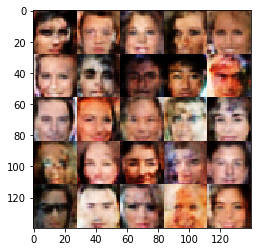

Step 3905/32 Epoch 1/1... Discriminator Loss: 1.0383... Generator Loss: 2.9998
Step 3910/32 Epoch 1/1... Discriminator Loss: 1.5448... Generator Loss: 2.9706
Step 3915/32 Epoch 1/1... Discriminator Loss: 1.4985... Generator Loss: 0.6712
Step 3920/32 Epoch 1/1... Discriminator Loss: 0.7982... Generator Loss: 2.6205
Step 3925/32 Epoch 1/1... Discriminator Loss: 0.7687... Generator Loss: 4.4310
Step 3930/32 Epoch 1/1... Discriminator Loss: 0.5469... Generator Loss: 3.0922
Step 3935/32 Epoch 1/1... Discriminator Loss: 0.4299... Generator Loss: 3.6772
Step 3940/32 Epoch 1/1... Discriminator Loss: 0.8071... Generator Loss: 2.1477
Step 3945/32 Epoch 1/1... Discriminator Loss: 0.4867... Generator Loss: 3.5262
Step 3950/32 Epoch 1/1... Discriminator Loss: 0.4480... Generator Loss: 3.4036
Step 3955/32 Epoch 1/1... Discriminator Loss: 0.6764... Generator Loss: 2.0799
Step 3960/32 Epoch 1/1... Discriminator Loss: 0.4677... Generator Loss: 3.3257
Step 3965/32 Epoch 1/1... Discriminator Loss: 1.2211

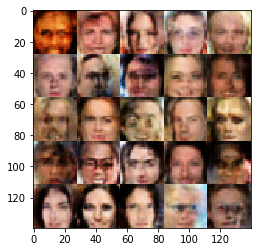

Step 4005/32 Epoch 1/1... Discriminator Loss: 1.1811... Generator Loss: 1.9647
Step 4010/32 Epoch 1/1... Discriminator Loss: 0.7165... Generator Loss: 1.2542
Step 4015/32 Epoch 1/1... Discriminator Loss: 1.2205... Generator Loss: 2.1978
Step 4020/32 Epoch 1/1... Discriminator Loss: 1.7469... Generator Loss: 0.2456
Step 4025/32 Epoch 1/1... Discriminator Loss: 1.5204... Generator Loss: 0.4341
Step 4030/32 Epoch 1/1... Discriminator Loss: 1.2435... Generator Loss: 0.8235
Step 4035/32 Epoch 1/1... Discriminator Loss: 0.5966... Generator Loss: 2.0032
Step 4040/32 Epoch 1/1... Discriminator Loss: 1.0479... Generator Loss: 0.8545
Step 4045/32 Epoch 1/1... Discriminator Loss: 0.7605... Generator Loss: 2.3112
Step 4050/32 Epoch 1/1... Discriminator Loss: 0.5398... Generator Loss: 2.5577
Step 4055/32 Epoch 1/1... Discriminator Loss: 0.9849... Generator Loss: 0.9436
Step 4060/32 Epoch 1/1... Discriminator Loss: 0.6509... Generator Loss: 1.5602
Step 4065/32 Epoch 1/1... Discriminator Loss: 0.9121

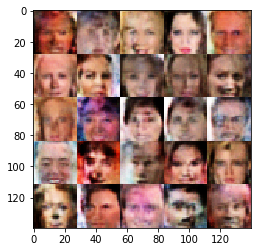

Step 4105/32 Epoch 1/1... Discriminator Loss: 0.5066... Generator Loss: 2.1867
Step 4110/32 Epoch 1/1... Discriminator Loss: 1.2093... Generator Loss: 1.0121
Step 4115/32 Epoch 1/1... Discriminator Loss: 1.2912... Generator Loss: 0.6035
Step 4120/32 Epoch 1/1... Discriminator Loss: 0.9412... Generator Loss: 1.0265
Step 4125/32 Epoch 1/1... Discriminator Loss: 0.7942... Generator Loss: 1.6300
Step 4130/32 Epoch 1/1... Discriminator Loss: 0.7217... Generator Loss: 1.3162
Step 4135/32 Epoch 1/1... Discriminator Loss: 0.5739... Generator Loss: 2.0103
Step 4140/32 Epoch 1/1... Discriminator Loss: 0.6396... Generator Loss: 2.3096
Step 4145/32 Epoch 1/1... Discriminator Loss: 0.5332... Generator Loss: 2.3175
Step 4150/32 Epoch 1/1... Discriminator Loss: 1.8337... Generator Loss: 1.9549
Step 4155/32 Epoch 1/1... Discriminator Loss: 1.1387... Generator Loss: 0.7678
Step 4160/32 Epoch 1/1... Discriminator Loss: 0.5819... Generator Loss: 2.8389
Step 4165/32 Epoch 1/1... Discriminator Loss: 0.9458

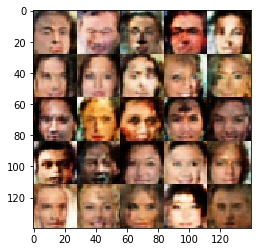

Step 4205/32 Epoch 1/1... Discriminator Loss: 0.8682... Generator Loss: 1.3571
Step 4210/32 Epoch 1/1... Discriminator Loss: 0.8564... Generator Loss: 1.0405
Step 4215/32 Epoch 1/1... Discriminator Loss: 0.5481... Generator Loss: 2.8946
Step 4220/32 Epoch 1/1... Discriminator Loss: 0.6453... Generator Loss: 1.7042
Step 4225/32 Epoch 1/1... Discriminator Loss: 1.2655... Generator Loss: 0.7039
Step 4230/32 Epoch 1/1... Discriminator Loss: 0.7202... Generator Loss: 3.4955
Step 4235/32 Epoch 1/1... Discriminator Loss: 0.4916... Generator Loss: 2.4542
Step 4240/32 Epoch 1/1... Discriminator Loss: 1.1606... Generator Loss: 0.7058
Step 4245/32 Epoch 1/1... Discriminator Loss: 2.3263... Generator Loss: 3.2417
Step 4250/32 Epoch 1/1... Discriminator Loss: 0.9665... Generator Loss: 1.0939
Step 4255/32 Epoch 1/1... Discriminator Loss: 0.6480... Generator Loss: 2.7355
Step 4260/32 Epoch 1/1... Discriminator Loss: 1.0575... Generator Loss: 0.8111
Step 4265/32 Epoch 1/1... Discriminator Loss: 0.9188

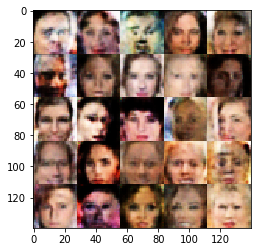

Step 4305/32 Epoch 1/1... Discriminator Loss: 0.8879... Generator Loss: 1.5699
Step 4310/32 Epoch 1/1... Discriminator Loss: 0.4692... Generator Loss: 3.0915
Step 4315/32 Epoch 1/1... Discriminator Loss: 0.4736... Generator Loss: 3.8500
Step 4320/32 Epoch 1/1... Discriminator Loss: 1.3004... Generator Loss: 1.4112
Step 4325/32 Epoch 1/1... Discriminator Loss: 0.3908... Generator Loss: 3.9792
Step 4330/32 Epoch 1/1... Discriminator Loss: 0.3893... Generator Loss: 3.9149
Step 4335/32 Epoch 1/1... Discriminator Loss: 0.6708... Generator Loss: 1.4790
Step 4340/32 Epoch 1/1... Discriminator Loss: 0.5020... Generator Loss: 3.1655
Step 4345/32 Epoch 1/1... Discriminator Loss: 0.5465... Generator Loss: 2.4116
Step 4350/32 Epoch 1/1... Discriminator Loss: 0.5852... Generator Loss: 2.9699
Step 4355/32 Epoch 1/1... Discriminator Loss: 1.0648... Generator Loss: 0.8463
Step 4360/32 Epoch 1/1... Discriminator Loss: 1.1646... Generator Loss: 0.7607
Step 4365/32 Epoch 1/1... Discriminator Loss: 0.4491

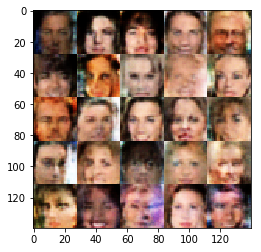

Step 4405/32 Epoch 1/1... Discriminator Loss: 0.3941... Generator Loss: 3.8685
Step 4410/32 Epoch 1/1... Discriminator Loss: 0.5083... Generator Loss: 2.1762
Step 4415/32 Epoch 1/1... Discriminator Loss: 1.0163... Generator Loss: 1.4445
Step 4420/32 Epoch 1/1... Discriminator Loss: 1.2821... Generator Loss: 0.6645
Step 4425/32 Epoch 1/1... Discriminator Loss: 0.7163... Generator Loss: 1.6629
Step 4430/32 Epoch 1/1... Discriminator Loss: 0.5681... Generator Loss: 2.2152
Step 4435/32 Epoch 1/1... Discriminator Loss: 0.6136... Generator Loss: 1.8657
Step 4440/32 Epoch 1/1... Discriminator Loss: 0.6348... Generator Loss: 3.9030
Step 4445/32 Epoch 1/1... Discriminator Loss: 0.4693... Generator Loss: 2.5348
Step 4450/32 Epoch 1/1... Discriminator Loss: 0.6076... Generator Loss: 1.8564
Step 4455/32 Epoch 1/1... Discriminator Loss: 1.4357... Generator Loss: 0.4388
Step 4460/32 Epoch 1/1... Discriminator Loss: 0.4938... Generator Loss: 2.3780
Step 4465/32 Epoch 1/1... Discriminator Loss: 0.4721

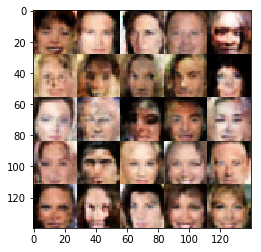

Step 4505/32 Epoch 1/1... Discriminator Loss: 0.5461... Generator Loss: 3.3959
Step 4510/32 Epoch 1/1... Discriminator Loss: 0.4599... Generator Loss: 3.2453
Step 4515/32 Epoch 1/1... Discriminator Loss: 0.5613... Generator Loss: 2.1856
Step 4520/32 Epoch 1/1... Discriminator Loss: 0.4305... Generator Loss: 4.4545
Step 4525/32 Epoch 1/1... Discriminator Loss: 1.4226... Generator Loss: 1.2116
Step 4530/32 Epoch 1/1... Discriminator Loss: 1.2430... Generator Loss: 1.4254
Step 4535/32 Epoch 1/1... Discriminator Loss: 0.4393... Generator Loss: 3.0092
Step 4540/32 Epoch 1/1... Discriminator Loss: 1.0601... Generator Loss: 1.1941
Step 4545/32 Epoch 1/1... Discriminator Loss: 1.1309... Generator Loss: 1.0497
Step 4550/32 Epoch 1/1... Discriminator Loss: 0.7190... Generator Loss: 1.3272
Step 4555/32 Epoch 1/1... Discriminator Loss: 0.7395... Generator Loss: 2.1277
Step 4560/32 Epoch 1/1... Discriminator Loss: 0.9357... Generator Loss: 1.2589
Step 4565/32 Epoch 1/1... Discriminator Loss: 0.4113

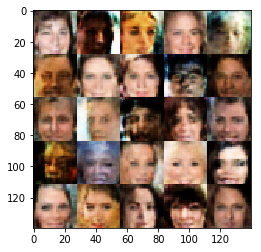

Step 4605/32 Epoch 1/1... Discriminator Loss: 0.6903... Generator Loss: 3.2656
Step 4610/32 Epoch 1/1... Discriminator Loss: 0.4322... Generator Loss: 3.5362
Step 4615/32 Epoch 1/1... Discriminator Loss: 0.6689... Generator Loss: 3.3652
Step 4620/32 Epoch 1/1... Discriminator Loss: 0.4391... Generator Loss: 3.5392
Step 4625/32 Epoch 1/1... Discriminator Loss: 1.5339... Generator Loss: 2.7133
Step 4630/32 Epoch 1/1... Discriminator Loss: 1.1995... Generator Loss: 0.7865
Step 4635/32 Epoch 1/1... Discriminator Loss: 0.8998... Generator Loss: 2.1191
Step 4640/32 Epoch 1/1... Discriminator Loss: 1.2207... Generator Loss: 0.6798
Step 4645/32 Epoch 1/1... Discriminator Loss: 0.6337... Generator Loss: 1.6680
Step 4650/32 Epoch 1/1... Discriminator Loss: 0.8596... Generator Loss: 1.0891
Step 4655/32 Epoch 1/1... Discriminator Loss: 0.5950... Generator Loss: 2.5827
Step 4660/32 Epoch 1/1... Discriminator Loss: 1.2954... Generator Loss: 0.6179
Step 4665/32 Epoch 1/1... Discriminator Loss: 0.9471

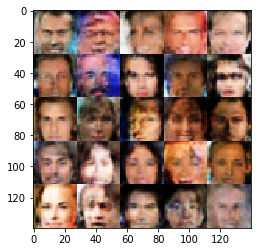

Step 4705/32 Epoch 1/1... Discriminator Loss: 0.4912... Generator Loss: 2.5643
Step 4710/32 Epoch 1/1... Discriminator Loss: 0.7058... Generator Loss: 3.5736
Step 4715/32 Epoch 1/1... Discriminator Loss: 0.5648... Generator Loss: 2.2023
Step 4720/32 Epoch 1/1... Discriminator Loss: 0.9033... Generator Loss: 1.4724
Step 4725/32 Epoch 1/1... Discriminator Loss: 0.9181... Generator Loss: 2.1194
Step 4730/32 Epoch 1/1... Discriminator Loss: 0.4439... Generator Loss: 2.4389
Step 4735/32 Epoch 1/1... Discriminator Loss: 0.4761... Generator Loss: 2.9702
Step 4740/32 Epoch 1/1... Discriminator Loss: 1.2368... Generator Loss: 2.3578
Step 4745/32 Epoch 1/1... Discriminator Loss: 0.4062... Generator Loss: 3.9554
Step 4750/32 Epoch 1/1... Discriminator Loss: 1.1687... Generator Loss: 1.3111
Step 4755/32 Epoch 1/1... Discriminator Loss: 0.6664... Generator Loss: 1.5868
Step 4760/32 Epoch 1/1... Discriminator Loss: 1.5125... Generator Loss: 3.0746
Step 4765/32 Epoch 1/1... Discriminator Loss: 0.7059

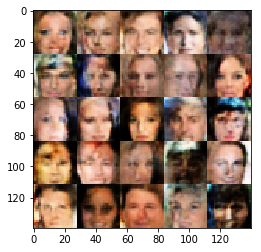

Step 4805/32 Epoch 1/1... Discriminator Loss: 0.7405... Generator Loss: 1.6657
Step 4810/32 Epoch 1/1... Discriminator Loss: 0.5264... Generator Loss: 2.7074
Step 4815/32 Epoch 1/1... Discriminator Loss: 0.4604... Generator Loss: 3.6763
Step 4820/32 Epoch 1/1... Discriminator Loss: 0.6698... Generator Loss: 3.6211
Step 4825/32 Epoch 1/1... Discriminator Loss: 0.4393... Generator Loss: 4.2752
Step 4830/32 Epoch 1/1... Discriminator Loss: 0.9223... Generator Loss: 1.2311
Step 4835/32 Epoch 1/1... Discriminator Loss: 0.4059... Generator Loss: 3.6757
Step 4840/32 Epoch 1/1... Discriminator Loss: 1.4642... Generator Loss: 2.3300
Step 4845/32 Epoch 1/1... Discriminator Loss: 0.5270... Generator Loss: 3.2336
Step 4850/32 Epoch 1/1... Discriminator Loss: 1.1463... Generator Loss: 2.4679
Step 4855/32 Epoch 1/1... Discriminator Loss: 0.9228... Generator Loss: 1.9111
Step 4860/32 Epoch 1/1... Discriminator Loss: 0.4660... Generator Loss: 3.0400
Step 4865/32 Epoch 1/1... Discriminator Loss: 0.9328

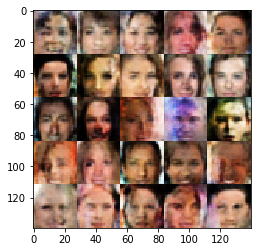

Step 4905/32 Epoch 1/1... Discriminator Loss: 0.8967... Generator Loss: 1.0524
Step 4910/32 Epoch 1/1... Discriminator Loss: 0.6515... Generator Loss: 1.5189
Step 4915/32 Epoch 1/1... Discriminator Loss: 0.9640... Generator Loss: 0.8633
Step 4920/32 Epoch 1/1... Discriminator Loss: 0.6381... Generator Loss: 1.7846
Step 4925/32 Epoch 1/1... Discriminator Loss: 1.2755... Generator Loss: 0.8722
Step 4930/32 Epoch 1/1... Discriminator Loss: 0.4745... Generator Loss: 2.6206
Step 4935/32 Epoch 1/1... Discriminator Loss: 1.7904... Generator Loss: 0.3200
Step 4940/32 Epoch 1/1... Discriminator Loss: 0.9417... Generator Loss: 0.9202
Step 4945/32 Epoch 1/1... Discriminator Loss: 1.0213... Generator Loss: 1.1344
Step 4950/32 Epoch 1/1... Discriminator Loss: 0.4857... Generator Loss: 2.4170
Step 4955/32 Epoch 1/1... Discriminator Loss: 0.7659... Generator Loss: 4.7623
Step 4960/32 Epoch 1/1... Discriminator Loss: 0.5681... Generator Loss: 2.4300
Step 4965/32 Epoch 1/1... Discriminator Loss: 1.0733

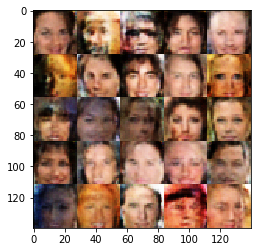

Step 5005/32 Epoch 1/1... Discriminator Loss: 0.5273... Generator Loss: 2.1579
Step 5010/32 Epoch 1/1... Discriminator Loss: 1.2120... Generator Loss: 0.7865
Step 5015/32 Epoch 1/1... Discriminator Loss: 0.8373... Generator Loss: 1.5972
Step 5020/32 Epoch 1/1... Discriminator Loss: 1.1332... Generator Loss: 0.6765
Step 5025/32 Epoch 1/1... Discriminator Loss: 0.5653... Generator Loss: 2.2753
Step 5030/32 Epoch 1/1... Discriminator Loss: 0.5221... Generator Loss: 3.0253
Step 5035/32 Epoch 1/1... Discriminator Loss: 0.6485... Generator Loss: 1.6755
Step 5040/32 Epoch 1/1... Discriminator Loss: 0.4115... Generator Loss: 3.2559
Step 5045/32 Epoch 1/1... Discriminator Loss: 0.5430... Generator Loss: 2.0964
Step 5050/32 Epoch 1/1... Discriminator Loss: 1.1254... Generator Loss: 1.4464
Step 5055/32 Epoch 1/1... Discriminator Loss: 1.1029... Generator Loss: 1.1105
Step 5060/32 Epoch 1/1... Discriminator Loss: 0.5895... Generator Loss: 2.6396
Step 5065/32 Epoch 1/1... Discriminator Loss: 0.5085

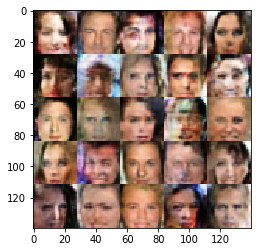

Step 5105/32 Epoch 1/1... Discriminator Loss: 1.4010... Generator Loss: 2.2422
Step 5110/32 Epoch 1/1... Discriminator Loss: 0.5158... Generator Loss: 2.0060
Step 5115/32 Epoch 1/1... Discriminator Loss: 0.5073... Generator Loss: 2.3808
Step 5120/32 Epoch 1/1... Discriminator Loss: 0.9619... Generator Loss: 1.1402
Step 5125/32 Epoch 1/1... Discriminator Loss: 1.1419... Generator Loss: 0.9460
Step 5130/32 Epoch 1/1... Discriminator Loss: 0.8290... Generator Loss: 1.6357
Step 5135/32 Epoch 1/1... Discriminator Loss: 0.8797... Generator Loss: 1.0576
Step 5140/32 Epoch 1/1... Discriminator Loss: 0.4080... Generator Loss: 4.5187
Step 5145/32 Epoch 1/1... Discriminator Loss: 0.8454... Generator Loss: 3.0537
Step 5150/32 Epoch 1/1... Discriminator Loss: 0.4286... Generator Loss: 2.7820
Step 5155/32 Epoch 1/1... Discriminator Loss: 1.1010... Generator Loss: 4.2740
Step 5160/32 Epoch 1/1... Discriminator Loss: 0.8567... Generator Loss: 1.3761
Step 5165/32 Epoch 1/1... Discriminator Loss: 0.5386

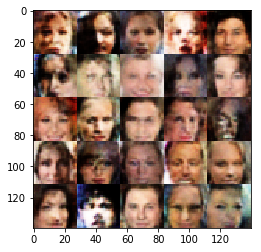

Step 5205/32 Epoch 1/1... Discriminator Loss: 1.1584... Generator Loss: 1.7691
Step 5210/32 Epoch 1/1... Discriminator Loss: 0.9058... Generator Loss: 1.1062
Step 5215/32 Epoch 1/1... Discriminator Loss: 0.5770... Generator Loss: 1.9789
Step 5220/32 Epoch 1/1... Discriminator Loss: 0.6723... Generator Loss: 1.7078
Step 5225/32 Epoch 1/1... Discriminator Loss: 0.4184... Generator Loss: 2.9684
Step 5230/32 Epoch 1/1... Discriminator Loss: 1.2498... Generator Loss: 2.1241
Step 5235/32 Epoch 1/1... Discriminator Loss: 0.4415... Generator Loss: 3.0813
Step 5240/32 Epoch 1/1... Discriminator Loss: 0.6316... Generator Loss: 1.6773
Step 5245/32 Epoch 1/1... Discriminator Loss: 1.4396... Generator Loss: 0.4936
Step 5250/32 Epoch 1/1... Discriminator Loss: 0.8357... Generator Loss: 1.5515
Step 5255/32 Epoch 1/1... Discriminator Loss: 1.0767... Generator Loss: 0.7060
Step 5260/32 Epoch 1/1... Discriminator Loss: 0.5820... Generator Loss: 1.9983
Step 5265/32 Epoch 1/1... Discriminator Loss: 1.0869

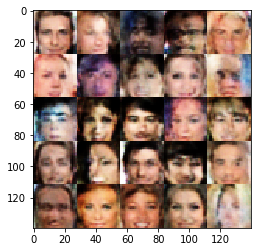

Step 5305/32 Epoch 1/1... Discriminator Loss: 1.2463... Generator Loss: 2.1563
Step 5310/32 Epoch 1/1... Discriminator Loss: 0.8346... Generator Loss: 1.2042
Step 5315/32 Epoch 1/1... Discriminator Loss: 0.4745... Generator Loss: 4.4632
Step 5320/32 Epoch 1/1... Discriminator Loss: 0.6990... Generator Loss: 1.4922
Step 5325/32 Epoch 1/1... Discriminator Loss: 1.4562... Generator Loss: 0.5776
Step 5330/32 Epoch 1/1... Discriminator Loss: 0.6948... Generator Loss: 1.9455
Step 5335/32 Epoch 1/1... Discriminator Loss: 1.1112... Generator Loss: 0.7355
Step 5340/32 Epoch 1/1... Discriminator Loss: 0.6233... Generator Loss: 2.8517
Step 5345/32 Epoch 1/1... Discriminator Loss: 1.2026... Generator Loss: 0.6914
Step 5350/32 Epoch 1/1... Discriminator Loss: 0.5604... Generator Loss: 2.0876
Step 5355/32 Epoch 1/1... Discriminator Loss: 0.5996... Generator Loss: 3.4936
Step 5360/32 Epoch 1/1... Discriminator Loss: 1.0755... Generator Loss: 2.2020
Step 5365/32 Epoch 1/1... Discriminator Loss: 1.8111

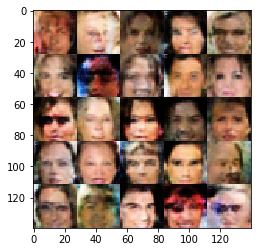

Step 5405/32 Epoch 1/1... Discriminator Loss: 0.9372... Generator Loss: 1.0725
Step 5410/32 Epoch 1/1... Discriminator Loss: 0.4938... Generator Loss: 3.0560
Step 5415/32 Epoch 1/1... Discriminator Loss: 0.3760... Generator Loss: 4.0211
Step 5420/32 Epoch 1/1... Discriminator Loss: 1.8816... Generator Loss: 0.8069
Step 5425/32 Epoch 1/1... Discriminator Loss: 1.8228... Generator Loss: 1.4812
Step 5430/32 Epoch 1/1... Discriminator Loss: 0.7102... Generator Loss: 1.5472
Step 5435/32 Epoch 1/1... Discriminator Loss: 1.1047... Generator Loss: 1.2932
Step 5440/32 Epoch 1/1... Discriminator Loss: 0.7746... Generator Loss: 1.8496
Step 5445/32 Epoch 1/1... Discriminator Loss: 1.0869... Generator Loss: 0.8976
Step 5450/32 Epoch 1/1... Discriminator Loss: 0.5142... Generator Loss: 2.2844
Step 5455/32 Epoch 1/1... Discriminator Loss: 0.6821... Generator Loss: 2.5747
Step 5460/32 Epoch 1/1... Discriminator Loss: 0.6023... Generator Loss: 2.4067
Step 5465/32 Epoch 1/1... Discriminator Loss: 1.0586

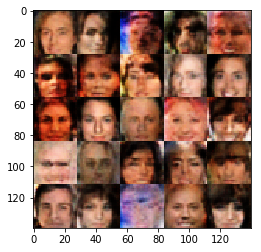

Step 5505/32 Epoch 1/1... Discriminator Loss: 1.0722... Generator Loss: 1.7028
Step 5510/32 Epoch 1/1... Discriminator Loss: 1.3388... Generator Loss: 1.5016
Step 5515/32 Epoch 1/1... Discriminator Loss: 0.7611... Generator Loss: 1.4142
Step 5520/32 Epoch 1/1... Discriminator Loss: 0.8105... Generator Loss: 1.1894
Step 5525/32 Epoch 1/1... Discriminator Loss: 0.8679... Generator Loss: 1.0225
Step 5530/32 Epoch 1/1... Discriminator Loss: 0.8186... Generator Loss: 2.1280
Step 5535/32 Epoch 1/1... Discriminator Loss: 1.0434... Generator Loss: 1.7218
Step 5540/32 Epoch 1/1... Discriminator Loss: 0.6157... Generator Loss: 1.8435
Step 5545/32 Epoch 1/1... Discriminator Loss: 0.9697... Generator Loss: 1.2283
Step 5550/32 Epoch 1/1... Discriminator Loss: 0.8858... Generator Loss: 1.1753
Step 5555/32 Epoch 1/1... Discriminator Loss: 1.0577... Generator Loss: 0.9522
Step 5560/32 Epoch 1/1... Discriminator Loss: 1.1735... Generator Loss: 0.7179
Step 5565/32 Epoch 1/1... Discriminator Loss: 0.4677

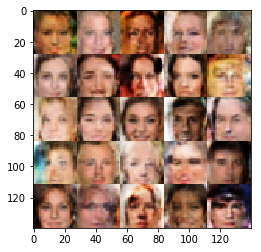

Step 5605/32 Epoch 1/1... Discriminator Loss: 1.1218... Generator Loss: 0.9205
Step 5610/32 Epoch 1/1... Discriminator Loss: 0.7261... Generator Loss: 1.4839
Step 5615/32 Epoch 1/1... Discriminator Loss: 0.8151... Generator Loss: 3.3924
Step 5620/32 Epoch 1/1... Discriminator Loss: 1.1728... Generator Loss: 2.9428
Step 5625/32 Epoch 1/1... Discriminator Loss: 0.7391... Generator Loss: 1.3214
Step 5630/32 Epoch 1/1... Discriminator Loss: 1.6397... Generator Loss: 3.0948
Step 5635/32 Epoch 1/1... Discriminator Loss: 0.6324... Generator Loss: 1.5045
Step 5640/32 Epoch 1/1... Discriminator Loss: 0.6845... Generator Loss: 1.1668
Step 5645/32 Epoch 1/1... Discriminator Loss: 0.4181... Generator Loss: 3.2514
Step 5650/32 Epoch 1/1... Discriminator Loss: 1.7761... Generator Loss: 0.4118
Step 5655/32 Epoch 1/1... Discriminator Loss: 0.7446... Generator Loss: 1.6462
Step 5660/32 Epoch 1/1... Discriminator Loss: 0.6406... Generator Loss: 2.1625
Step 5665/32 Epoch 1/1... Discriminator Loss: 0.6001

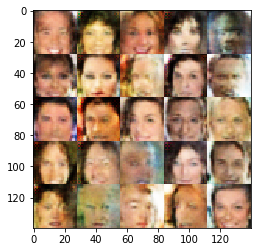

Step 5705/32 Epoch 1/1... Discriminator Loss: 0.3917... Generator Loss: 3.7029
Step 5710/32 Epoch 1/1... Discriminator Loss: 1.1617... Generator Loss: 0.7831
Step 5715/32 Epoch 1/1... Discriminator Loss: 1.0396... Generator Loss: 4.5666
Step 5720/32 Epoch 1/1... Discriminator Loss: 0.8908... Generator Loss: 0.9716
Step 5725/32 Epoch 1/1... Discriminator Loss: 0.8864... Generator Loss: 1.1678
Step 5730/32 Epoch 1/1... Discriminator Loss: 1.3601... Generator Loss: 0.5580
Step 5735/32 Epoch 1/1... Discriminator Loss: 0.6908... Generator Loss: 2.1088
Step 5740/32 Epoch 1/1... Discriminator Loss: 0.5186... Generator Loss: 3.6506
Step 5745/32 Epoch 1/1... Discriminator Loss: 0.5091... Generator Loss: 2.2028
Step 5750/32 Epoch 1/1... Discriminator Loss: 0.7610... Generator Loss: 1.3758
Step 5755/32 Epoch 1/1... Discriminator Loss: 0.9914... Generator Loss: 1.7480
Step 5760/32 Epoch 1/1... Discriminator Loss: 0.8334... Generator Loss: 1.3515
Step 5765/32 Epoch 1/1... Discriminator Loss: 1.6624

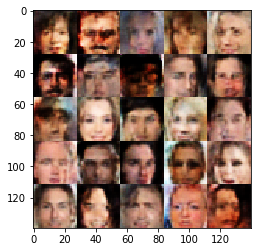

Step 5805/32 Epoch 1/1... Discriminator Loss: 0.5813... Generator Loss: 1.8464
Step 5810/32 Epoch 1/1... Discriminator Loss: 0.7901... Generator Loss: 1.2749
Step 5815/32 Epoch 1/1... Discriminator Loss: 0.8369... Generator Loss: 1.4997
Step 5820/32 Epoch 1/1... Discriminator Loss: 0.7906... Generator Loss: 1.5881
Step 5825/32 Epoch 1/1... Discriminator Loss: 0.8351... Generator Loss: 1.5294
Step 5830/32 Epoch 1/1... Discriminator Loss: 1.2388... Generator Loss: 0.7469
Step 5835/32 Epoch 1/1... Discriminator Loss: 2.1135... Generator Loss: 2.5703
Step 5840/32 Epoch 1/1... Discriminator Loss: 0.6397... Generator Loss: 3.8321
Step 5845/32 Epoch 1/1... Discriminator Loss: 0.4689... Generator Loss: 2.7656
Step 5850/32 Epoch 1/1... Discriminator Loss: 0.4984... Generator Loss: 2.1872
Step 5855/32 Epoch 1/1... Discriminator Loss: 0.9190... Generator Loss: 1.0779
Step 5860/32 Epoch 1/1... Discriminator Loss: 0.6510... Generator Loss: 1.5559
Step 5865/32 Epoch 1/1... Discriminator Loss: 0.5427

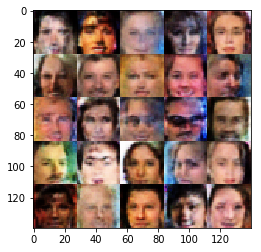

Step 5905/32 Epoch 1/1... Discriminator Loss: 0.7022... Generator Loss: 3.1085
Step 5910/32 Epoch 1/1... Discriminator Loss: 0.9798... Generator Loss: 0.9166
Step 5915/32 Epoch 1/1... Discriminator Loss: 0.7958... Generator Loss: 1.8505
Step 5920/32 Epoch 1/1... Discriminator Loss: 0.6151... Generator Loss: 2.3065
Step 5925/32 Epoch 1/1... Discriminator Loss: 0.4361... Generator Loss: 2.8021
Step 5930/32 Epoch 1/1... Discriminator Loss: 0.7352... Generator Loss: 1.4641
Step 5935/32 Epoch 1/1... Discriminator Loss: 0.5895... Generator Loss: 2.3403
Step 5940/32 Epoch 1/1... Discriminator Loss: 0.5108... Generator Loss: 3.5394
Step 5945/32 Epoch 1/1... Discriminator Loss: 0.6163... Generator Loss: 3.4996
Step 5950/32 Epoch 1/1... Discriminator Loss: 0.9928... Generator Loss: 0.9100
Step 5955/32 Epoch 1/1... Discriminator Loss: 0.8030... Generator Loss: 1.0712
Step 5960/32 Epoch 1/1... Discriminator Loss: 1.9897... Generator Loss: 3.4131
Step 5965/32 Epoch 1/1... Discriminator Loss: 0.7763

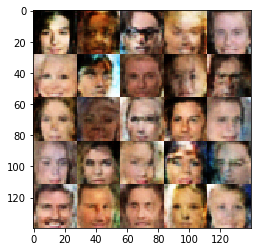

Step 6005/32 Epoch 1/1... Discriminator Loss: 0.6685... Generator Loss: 1.5435
Step 6010/32 Epoch 1/1... Discriminator Loss: 1.2244... Generator Loss: 0.6400
Step 6015/32 Epoch 1/1... Discriminator Loss: 0.9332... Generator Loss: 1.9301
Step 6020/32 Epoch 1/1... Discriminator Loss: 0.3989... Generator Loss: 4.0759
Step 6025/32 Epoch 1/1... Discriminator Loss: 0.5170... Generator Loss: 3.1657
Step 6030/32 Epoch 1/1... Discriminator Loss: 1.1103... Generator Loss: 0.8486
Step 6035/32 Epoch 1/1... Discriminator Loss: 1.1355... Generator Loss: 0.7427
Step 6040/32 Epoch 1/1... Discriminator Loss: 1.1946... Generator Loss: 0.7509
Step 6045/32 Epoch 1/1... Discriminator Loss: 0.4710... Generator Loss: 3.0471
Step 6050/32 Epoch 1/1... Discriminator Loss: 1.1023... Generator Loss: 0.7455
Step 6055/32 Epoch 1/1... Discriminator Loss: 1.5070... Generator Loss: 0.4164
Step 6060/32 Epoch 1/1... Discriminator Loss: 0.4422... Generator Loss: 2.8043
Step 6065/32 Epoch 1/1... Discriminator Loss: 0.9770

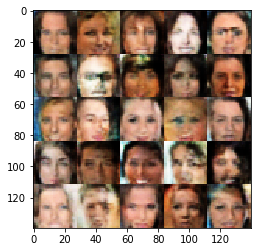

Step 6105/32 Epoch 1/1... Discriminator Loss: 1.6186... Generator Loss: 0.3700
Step 6110/32 Epoch 1/1... Discriminator Loss: 0.5866... Generator Loss: 1.9546
Step 6115/32 Epoch 1/1... Discriminator Loss: 0.5780... Generator Loss: 1.8701
Step 6120/32 Epoch 1/1... Discriminator Loss: 1.2010... Generator Loss: 1.3770
Step 6125/32 Epoch 1/1... Discriminator Loss: 0.7841... Generator Loss: 1.2312
Step 6130/32 Epoch 1/1... Discriminator Loss: 0.6361... Generator Loss: 1.6178
Step 6135/32 Epoch 1/1... Discriminator Loss: 0.9423... Generator Loss: 3.3781
Step 6140/32 Epoch 1/1... Discriminator Loss: 0.5250... Generator Loss: 3.4482
Step 6145/32 Epoch 1/1... Discriminator Loss: 0.5139... Generator Loss: 3.4110
Step 6150/32 Epoch 1/1... Discriminator Loss: 0.6252... Generator Loss: 2.7106
Step 6155/32 Epoch 1/1... Discriminator Loss: 0.8686... Generator Loss: 1.3380
Step 6160/32 Epoch 1/1... Discriminator Loss: 0.9108... Generator Loss: 0.9863
Step 6165/32 Epoch 1/1... Discriminator Loss: 1.1486

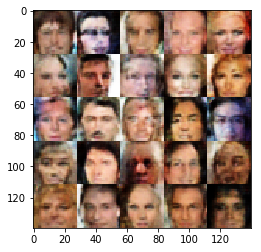

Step 6205/32 Epoch 1/1... Discriminator Loss: 1.1820... Generator Loss: 1.9499
Step 6210/32 Epoch 1/1... Discriminator Loss: 0.4459... Generator Loss: 2.7691
Step 6215/32 Epoch 1/1... Discriminator Loss: 0.5046... Generator Loss: 2.3455
Step 6220/32 Epoch 1/1... Discriminator Loss: 0.6239... Generator Loss: 1.8325
Step 6225/32 Epoch 1/1... Discriminator Loss: 0.8531... Generator Loss: 3.0931
Step 6230/32 Epoch 1/1... Discriminator Loss: 0.4837... Generator Loss: 2.4076
Step 6235/32 Epoch 1/1... Discriminator Loss: 0.6480... Generator Loss: 1.8280
Step 6240/32 Epoch 1/1... Discriminator Loss: 0.7187... Generator Loss: 2.0014
Step 6245/32 Epoch 1/1... Discriminator Loss: 1.6177... Generator Loss: 1.4266
Step 6250/32 Epoch 1/1... Discriminator Loss: 0.9290... Generator Loss: 1.1384
Step 6255/32 Epoch 1/1... Discriminator Loss: 1.2176... Generator Loss: 0.6707
Step 6260/32 Epoch 1/1... Discriminator Loss: 0.7814... Generator Loss: 1.1215
Step 6265/32 Epoch 1/1... Discriminator Loss: 1.6689

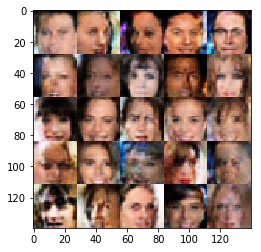

Step 6305/32 Epoch 1/1... Discriminator Loss: 1.1568... Generator Loss: 1.1857
Step 6310/32 Epoch 1/1... Discriminator Loss: 0.4820... Generator Loss: 4.0335
Step 6315/32 Epoch 1/1... Discriminator Loss: 0.6128... Generator Loss: 1.8468
Step 6320/32 Epoch 1/1... Discriminator Loss: 1.4210... Generator Loss: 0.6107
Step 6325/32 Epoch 1/1... Discriminator Loss: 0.8697... Generator Loss: 2.6597
Step 6330/32 Epoch 1/1... Discriminator Loss: 0.5865... Generator Loss: 2.6635


In [13]:
batch_size = 32
z_dim = 100
learning_rate = 0.0001
beta1 = 0.1


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.